In [1]:
import logging
import warnings

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')

In [3]:
logger.info("start")

INFO:__main__:start


In [4]:
from datasets import load_dataset

INFO:datasets:PyTorch version 2.7.1 available.


In [5]:
dataset = load_dataset('jfleg')

In [6]:
dataset["validation"]["sentence"][0]

'So I think we can not live if old people could not find siences and tecnologies and they did not developped . '

In [7]:
dataset["validation"]["corrections"][0]

['So I think we would not be alive if our ancestors did not develop sciences and technologies . ',
 'So I think we could not live if older people did not develop science and technologies . ',
 'So I think we can not live if old people could not find science and technologies and they did not develop . ',
 'So I think we can not live if old people can not find the science and technology that has not been developed . ']

In [8]:
len(dataset["validation"])

755

In [9]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 755
    })
    test: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 748
    })
})

In [10]:
from transformers import AutoTokenizer, T5ForConditionalGeneration
# MODELNAME = "vennify/t5-base-grammar-correction"
MODELNAME = "t5-small"
PREFIX = "grammar: "
tokenizer = AutoTokenizer.from_pretrained(MODELNAME)
model = T5ForConditionalGeneration.from_pretrained(MODELNAME)

In [11]:
# Define the input text with a task prefix
input_text = PREFIX + "he go to school yesterday."

# Tokenize the input
input_ids = tokenizer.encode(
    input_text, return_tensors="pt", max_length=128, truncation=True)

# Generate output (corrected text)
output = model.generate(
    input_ids,
    max_length=128,
    num_beams=5,  # Beam search for better quality
    early_stopping=True,
    repetition_penalty=2.5  # Penalize repetitive output
)

# Decode the generated text
corrected_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(f"Original: he go to school yesterday.")
print(f"Corrected: {corrected_text}")

Original: he go to school yesterday.
Corrected: grammar: he go to school yesterday.


In [12]:
isinstance(output, tuple)

False

In [13]:
corrected_text.lower().startswith("grammar:")
corrected_text[len("grammar: "):].strip()

'he go to school yesterday.'

In [14]:
tokenizer.decode(output[0], skip_special_tokens=True)

'grammar: he go to school yesterday.'

In [15]:
ds = load_dataset("dim/grammarly_coedit")

In [16]:
input_ids

tensor([[19519,    10,     3,    88,   281,    12,   496,  4981,     5,     1]])

In [17]:
type(dataset["validation"]["sentence"])

list

In [18]:
from transformers import T5Config

In [19]:
print(T5Config())

T5Config {
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.52.4",
  "use_cache": true,
  "vocab_size": 32128
}



In [20]:
from torch.utils.data import DataLoader, Dataset
import torch

In [21]:
class GrammarCorrectionDataset(Dataset):
    """A PyTorch Dataset for grammar correction tasks.

    This dataset takes input text with grammatical errors and their corrected target text,
    tokenizes them using the provided tokenizer, and prepares them for training a grammar
    correction model.

    Args:
                                    tokenizer: The tokenizer to use for encoding the text
                                    input_text (list): List of input texts containing grammatical errors
                                    target_text (list): List of corresponding corrected texts
                                    max_length (int, optional): Maximum sequence length for tokenization. Defaults to 256.

    Returns:
                                    dict: Dictionary containing:
                                                                    - input_ids: Tokenized and padded input text
                                                                    - attention_mask: Attention mask for input text
                                                                    - labels: Target labels for training (-100 for padding tokens)
    """

    def __init__(self, tokenizer, input_text, target_text, max_length=256):
        self.tokenizer = tokenizer
        self.input_text = input_text
        self.target_text = target_text
        self.max_length = max_length

    def __len__(self):
        return len(self.input_text)

    def __getitem__(self, id):
        source = str("grammar: " + self.input_text[id])
        target = str(self.target_text[id])

        source_tokens = self.tokenizer(
            source, return_tensors="pt", max_length=self.max_length,
            padding="max_length", truncation=True, return_attention_mask=True)

        target_tokens = self.tokenizer(
            target, return_tensors="pt", max_length=self.max_length,
            padding="max_length", truncation=True, return_attention_mask=True)

        labels = target_tokens["input_ids"].clone()
        labels[labels == tokenizer.pad_token_id] = -100

        return {
            "input_ids": source_tokens["input_ids"].flatten(),
            "attention_mask": source_tokens["attention_mask"].flatten(),
            "labels": labels.flatten(),
        }

In [22]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 755
    })
    test: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 748
    })
})

In [23]:
train_source = dataset["validation"]["sentence"]
train_labels = dataset["validation"]["corrections"]

val_source = dataset["test"]["sentence"]
val_labels = dataset["test"]["corrections"]

In [24]:
train_dataset = GrammarCorrectionDataset(tokenizer, train_source, train_labels)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [25]:
val_dataset = GrammarCorrectionDataset(tokenizer, val_source, val_labels)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)

In [26]:
MODELNAME

't5-small'

In [27]:
from transformers import TrainingArguments, Trainer

In [28]:

train_loader

In [29]:
for i, data in enumerate(train_loader):
    print(data)
    break

{'input_ids': tensor([[19519,    10,   299,   912,    13,   149,    25,    54,  4602,    48,
           682,    56,   700,   428,    25,     3,     9,  1127,    12,     8,
           682,     3,     5,     1,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [30]:
dataset["validation"]["sentence"][0]  # type: ignore

'So I think we can not live if old people could not find siences and tecnologies and they did not developped . '

In [31]:
tokenizer(
    # type: ignore
    str("grammar: " + dataset["validation"]["sentence"][0]),
    max_length=128, padding="max_length", truncation=True, return_tensors="pt",
    return_attention_mask=True)

{'input_ids': tensor([[19519,    10,   264,    27,   317,    62,    54,    59,   619,     3,
            99,   625,   151,   228,    59,   253,   108,  1433,     7,    11,
             3,  5822,    29,  4137,     7,    11,    79,   410,    59,  1344,
          3138,     3,     5,     1,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [32]:
text = "ArithmeticError"

In [33]:
# Define the input text with a task prefix
input_text = PREFIX + "he go to school yesterday."

# Tokenize the input
input_ids = tokenizer.encode(
    input_text, return_tensors="pt", max_length=128, truncation=True)

# Generate output (corrected text)
output = model.generate(
    input_ids,
    max_length=128,
    num_beams=5,  # Beam search for better quality
    early_stopping=True,
    repetition_penalty=2.5  # Penalize repetitive output
)

# Decode the generated text
corrected_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(f"Original: he go to school yesterday.")
print(f"Corrected: {corrected_text}")

Original: he go to school yesterday.
Corrected: grammar: he go to school yesterday.


In [34]:
wi_dataset = load_dataset("wi_locness", "wi", trust_remote_code=True)

In [35]:
wi_dataset["train"]

Dataset({
    features: ['id', 'userid', 'cefr', 'text', 'edits'],
    num_rows: 3000
})

In [36]:
wi_dataset["train"]["text"][0]

'My town is a medium size city with eighty thousand inhabitants. It has a high density population because its small territory. Despite of it is an industrial city, there are many shops and department stores.  I recommend visiting the artificial lake in the certer of the city which is surrounded by a park. Pasteries are very common and most of them offer the special dessert from the city. There are a comercial zone along the widest street of the city where you can find all kind of establishments: banks, bars, chemists, cinemas, pet shops, restaurants, fast food restaurants, groceries, travel agencies, supermarkets and others. Most of the shops have sales and offers at least three months of the year: January, June and August. The quality of the products and services are quite good, because there are a huge competition, however I suggest you taking care about some fakes or cheats.'

In [37]:
wi_dataset["train"]["edits"][0].keys()

dict_keys(['start', 'end', 'text'])

In [38]:
starts = wi_dataset["train"]["edits"][0]["start"]

In [39]:
ends = wi_dataset["train"]["edits"][0]["end"]

In [40]:
wi_dataset["train"]["text"][0][starts[0]:ends[0]]

'medium size'

In [41]:
wi_dataset["train"]["edits"][0]["text"][0]

'medium-sized'

In [42]:
text = wi_dataset["train"]["text"][0]
edits = wi_dataset["train"]["edits"][0]

In [43]:
edits

{'start': [13,
  77,
  104,
  126,
  134,
  256,
  306,
  375,
  396,
  402,
  476,
  484,
  579,
  671,
  774,
  804,
  808,
  826,
  838,
  850,
  857,
  862,
  868],
 'end': [24,
  78,
  104,
  133,
  136,
  262,
  315,
  379,
  399,
  411,
  480,
  498,
  588,
  671,
  777,
  807,
  810,
  835,
  845,
  856,
  861,
  867,
  873],
 'text': ['medium-sized',
  '-',
  ' of',
  'Although',
  '',
  'center',
  None,
  'of',
  'is',
  'commercial',
  'kinds',
  'businesses',
  'grocers',
  ' in',
  'is',
  'is',
  '',
  '. However,',
  'recommend',
  'be',
  'careful',
  'of',
  '']}

In [44]:
edits_list = list(zip(edits["start"], edits["end"], edits["text"]))
edits_list.sort(key=lambda x: x[0], reverse=True)

str = text
for start, end, replacement in edits_list:
    print(replacement)
    if replacement == None:
        replacement = ""
    str = str[:start] + replacement + str[end:]


of
careful
be
recommend
. However,

is
is
 in
grocers
businesses
kinds
commercial
is
of
None
center

Although
 of
-
medium-sized


In [45]:
str

'My town is a medium-sized city with eighty thousand inhabitants. It has a high-density population because of its small territory. Although  it is an industrial city, there are many shops and department stores.  I recommend visiting the artificial lake in the center of the city which is surrounded by a park.  are very common and most of them offer the special dessert of the city. There is a commercial zone along the widest street of the city where you can find all kinds of businesses: banks, bars, chemists, cinemas, pet shops, restaurants, fast food restaurants, grocers, travel agencies, supermarkets and others. Most of the shops have sales and offers in at least three months of the year: January, June and August. The quality of the products and services is quite good, because there is huge competition. However, I recommend you be careful of fakes or cheats.'

In [46]:
edits_list.sort(key=lambda x: x[0], reverse=True)
edits_list

[(868, 873, ''),
 (862, 867, 'of'),
 (857, 861, 'careful'),
 (850, 856, 'be'),
 (838, 845, 'recommend'),
 (826, 835, '. However,'),
 (808, 810, ''),
 (804, 807, 'is'),
 (774, 777, 'is'),
 (671, 671, ' in'),
 (579, 588, 'grocers'),
 (484, 498, 'businesses'),
 (476, 480, 'kinds'),
 (402, 411, 'commercial'),
 (396, 399, 'is'),
 (375, 379, 'of'),
 (306, 315, None),
 (256, 262, 'center'),
 (134, 136, ''),
 (126, 133, 'Although'),
 (104, 104, ' of'),
 (77, 78, '-'),
 (13, 24, 'medium-sized')]

In [47]:
wi_dataset.keys()

dict_keys(['train', 'validation'])

In [48]:
wi_ds = {}
for sets in wi_dataset.keys():
    for features in wi_dataset[sets]:
        incorrect_text = ""
        correct_text = ""
        if "text" in features and "edits" in features:
            incorrect_text = features["text"]  # type: ignore
            # print(incorrect_text)
            correct_text = features["text"]

            correct_list = features["edits"]

            edits_list = list(zip(correct_list["start"],
                                  correct_list["end"], correct_list["text"]))
            edits_list.sort(key=lambda x: x[0], reverse=True)

            for start, end, replacement in edits_list:
                if replacement == None:
                    replacement = ""
                correct_text = correct_text[:start] + \
                    replacement + correct_text[end:]

        if sets not in wi_ds:
            wi_ds[sets] = {"incorrect_text": [], "correct_text": []}

        if incorrect_text != correct_text:
            wi_ds[sets]["incorrect_text"].append(incorrect_text)
            wi_ds[sets]["correct_text"].append(correct_text)        # break

In [49]:
wi_ds["train"]["correct_text"][0]

'My town is a medium-sized city with eighty thousand inhabitants. It has a high-density population because of its small territory. Although  it is an industrial city, there are many shops and department stores.  I recommend visiting the artificial lake in the center of the city which is surrounded by a park.  are very common and most of them offer the special dessert of the city. There is a commercial zone along the widest street of the city where you can find all kinds of businesses: banks, bars, chemists, cinemas, pet shops, restaurants, fast food restaurants, grocers, travel agencies, supermarkets and others. Most of the shops have sales and offers in at least three months of the year: January, June and August. The quality of the products and services is quite good, because there is huge competition. However, I recommend you be careful of fakes or cheats.'

In [50]:
import numpy as np

In [51]:
np.max([len(wi_ds["train"]["incorrect_text"][i].split())
        for i in range(len(wi_ds["train"]["incorrect_text"]))])

np.int64(1551)

In [52]:
wi_ds.keys()

dict_keys(['train', 'validation'])

In [53]:
paws = load_dataset("paws", "labeled_final")

In [54]:
paraphrases = paws.filter(lambda x: x['label'] == 1)

In [55]:
paraphrases

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 21829
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 3536
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 3539
    })
})

In [56]:
# Setup comprehensive logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [57]:
def verify_environment():
    """Verify computational environment and requirements"""
    logger.info("🔍 ENVIRONMENT VERIFICATION")
    logger.info("=" * 50)
    logger.info(f"   PyTorch: {torch.__version__}")
    logger.info(f"   CUDA Available: {torch.cuda.is_available()}")

    if torch.cuda.is_available():
        gpu_props = torch.cuda.get_device_properties(0)
        logger.info(f"   GPU: {torch.cuda.get_device_name()}")
        logger.info(f"   GPU Memory: {gpu_props.total_memory / 1e9:.1f} GB")
        logger.info(f"   CUDA Version: {torch.version.cuda}")
    else:
        logger.warning("   ⚠️  No GPU detected - training will be slower")

    # Check available memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        memory_allocated = torch.cuda.memory_allocated() / 1e9
        memory_reserved = torch.cuda.memory_reserved() / 1e9
        logger.info(f"   GPU Memory Used: {memory_allocated:.1f} GB")
        logger.info(f"   GPU Memory Reserved: {memory_reserved:.1f} GB")

    logger.info("✅ Environment verification complete!")
    logger.info("=" * 50)


verify_environment()

INFO:__main__:🔍 ENVIRONMENT VERIFICATION
INFO:__main__:==================================================
INFO:__main__:   PyTorch: 2.7.1+cpu
INFO:__main__:   CUDA Available: False
INFO:__main__:✅ Environment verification complete!
INFO:__main__:==================================================


In [58]:
train_source = ["grammar: " +
                sentence for sentence in dataset["validation"]["sentence"]]
train_target = [correction[0]
                for correction in dataset["validation"]["corrections"]]

In [59]:
source_tokens = tokenizer(train_source, max_length=256,
                          truncation=True, padding=False)
target_tokens = tokenizer(train_target, max_length=256,
                          truncation=True, padding=False)

In [60]:
token_dataset = source_tokens
token_dataset["labels"] = target_tokens["input_ids"]

In [61]:
token_dataset.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [62]:
dataset.column_names

{'validation': ['sentence', 'corrections'],
 'test': ['sentence', 'corrections']}

In [63]:
def preprocess(sources, target, max_length=256):
    dataset = {}
    source = [f"grammar: {sentence}" for sentence in sources]
    targets = [correction[0]
               for correction in target]

    source_tokens = tokenizer(source, max_length=max_length,
                              truncation=True, padding=False,
                              return_tensors=None)
    target_tokens = tokenizer(targets, max_length=max_length,
                              truncation=True, padding=False,
                              return_tensors=None)
    # print(target_tokens)

    dataset["input_ids"] = source_tokens["input_ids"]
    dataset["attention_mask"] = source_tokens["attention_mask"]
    dataset["labels"] = target_tokens["input_ids"]

    return dataset

In [64]:
train_ds = dataset["validation"].map(lambda ds: preprocess(dataset["validation"]["sentence"],
                                                           dataset["validation"]["corrections"]),
                                     batched=True,
                                     remove_columns=dataset["validation"].column_names)

In [65]:
val_ds = dataset["test"].map(lambda ds: preprocess(dataset["test"]["sentence"],
                                                   dataset["test"]["corrections"]),
                             batched=True,
                             remove_columns=dataset["test"].column_names)

In [66]:
val_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 748
})

In [67]:
training_arg = TrainingArguments(
    output_dir=r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment2\Checkpoints",
    # Basic setup
    overwrite_output_dir=False,          # Overwrite output directory if exists
    do_train=True,                       # Whether to run training
    do_eval=False,                       # Whether to run evaluation
    do_predict=False,                    # Whether to run predictions

    # Training hyperparameters
    num_train_epochs=1.0,                # Number of training epochs
    # Max training steps (overrides epochs if set)
    max_steps=-1,
    per_device_train_batch_size=8,       # Batch size per device during training
    per_device_eval_batch_size=8,        # Batch size per device during evaluation
    gradient_accumulation_steps=1,        # Steps to accumulate gradients

    # Learning rate and optimization
    learning_rate=5e-5,                  # Initial learning rate
    weight_decay=0.0,                    # Weight decay coefficient
    adam_beta1=0.9,                      # Beta1 for Adam optimizer
    adam_beta2=0.999,                    # Beta2 for Adam optimizer
    adam_epsilon=1e-8,                   # Epsilon for Adam optimizer
    max_grad_norm=1.0,                   # Max gradient norm for clipping

    # Learning rate scheduling
    lr_scheduler_type="linear",          # Type of LR scheduler
    warmup_ratio=0.0,                    # Ratio of warmup steps
    warmup_steps=0,
)

In [68]:
from transformers import DataCollatorForSeq2Seq

In [69]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    return_tensors="pt"
)

In [70]:
trainer = Trainer(
    model=model,                        # The model to train/evaluate/predict
    args=training_arg,                         # TrainingArguments instance
    data_collator=data_collator,                # Function to collate batch data
    train_dataset=train_ds,                # Training dataset
    eval_dataset=val_ds,                 # Evaluation dataset
    tokenizer=tokenizer,                    # Tokenizer for the model
)

In [71]:
# trainer.train()

In [72]:
trainer.state.log_history

[]

In [73]:
dataset["validation"][0]

{'sentence': 'So I think we can not live if old people could not find siences and tecnologies and they did not developped . ',
 'corrections': ['So I think we would not be alive if our ancestors did not develop sciences and technologies . ',
  'So I think we could not live if older people did not develop science and technologies . ',
  'So I think we can not live if old people could not find science and technologies and they did not develop . ',
  'So I think we can not live if old people can not find the science and technology that has not been developed . ']}

In [74]:
import re

In [75]:
augmented_data = []
punc = re.compile(r'\s+([.!?,:;])')
for items in dataset["validation"]:
    print(type(items))
    source = punc.sub(r"\1", items["sentence"])
    print(source)
    targets = items["corrections"]
    for correction in targets:
        print(re.sub(punc, r"\1", correction))
        if correction.strip():
            augmented_data.append({
                "sentence": f"grammar: {source}",
                "correction": correction,
                "original_sentence": source,
                "all_corrections": targets
            })
    break

<class 'dict'>
So I think we can not live if old people could not find siences and tecnologies and they did not developped. 
So I think we would not be alive if our ancestors did not develop sciences and technologies. 
So I think we could not live if older people did not develop science and technologies. 
So I think we can not live if old people could not find science and technologies and they did not develop. 
So I think we can not live if old people can not find the science and technology that has not been developed. 


In [76]:
from typing import Dict, List, Tuple, Optional
from sklearn.model_selection import train_test_split
import re

In [77]:
split_number = r'\b(\d+(?:\s+\d+)+)\b'

In [78]:
class JFLEGDataset:
    """
    A comprehensive dataset processor for JFLEG (JHU FLuency-Extended GUG) grammar correction data.

    This class handles the complete pipeline for preparing JFLEG data for T5-based grammar correction
    training, including data loading, preprocessing, augmentation, tokenization, and train/validation/test
    splitting. The JFLEG dataset contains 1,511 examples with 4 human-written corrections each, focusing
    on fluency improvements rather than minimal edits.

    Key Features:
            - Comprehensive text preprocessing to handle formatting issues
            - Data augmentation using all 4 JFLEG corrections per sentence
            - Proper tokenization for T5 sequence-to-sequence training
            - Train/validation/test splitting with preserved evaluation metadata
            - Temperature-scaled mixing support for multi-task learning

    Dataset Sources:
            - Training: JFLEG validation split with 4x augmentation (~6,044 examples)
            - Validation/Test: JFLEG test split without augmentation, then split 90%/10%

    Attributes:
            tokenizer (T5Tokenizer): T5 tokenizer for text processing
            max_length (int): Maximum sequence length for tokenization
            test_split_ratio (float): Proportion of validation data to use for testing
            train_data (Dataset): JFLEG validation split used for training
            validation_data (Dataset): JFLEG test split used for validation/testing

    Example:
            >>> from transformers import T5Tokenizer
            >>> tokenizer = T5Tokenizer.from_pretrained("t5-base")
            >>> dataset = JFLEGDataset(tokenizer, max_length=256, test_split_ratio=0.10)
            >>> train_data, val_data, test_data = dataset.create_train_val_test_datasets()

    References:
            - JFLEG Paper: Napoles et al. (2017) "JFLEG: A Fluency Corpus and Benchmark 
              for Grammatical Error Correction"
            - Dataset: https://huggingface.co/datasets/jhu-clsp/jfleg
    """

    def __init__(self, tokenizer, max_length=256, test_split_ratio=0.10):
        """
        Initialize the JFLEG dataset processor with specified configuration.

        Sets up the dataset processor with the provided tokenizer and configuration
        parameters, then loads the raw JFLEG datasets for subsequent processing.

        Args:
                tokenizer (T5Tokenizer): HuggingFace T5 tokenizer instance for text processing.
                        Must be a properly initialized T5 tokenizer (e.g., from t5-base).
                max_length (int, optional): Maximum sequence length for tokenization. 
                        Sequences longer than this will be truncated. Defaults to 256.
                        Recommended range: 128-512 depending on GPU memory constraints.
                test_split_ratio (float, optional): Proportion of validation data to reserve 
                        for final testing. Must be between 0.0 and 1.0. Defaults to 0.10 (10%).
                        The remaining validation data will be used for model validation during training.

        Raises:
                ValueError: If test_split_ratio is not between 0.0 and 1.0
                TypeError: If tokenizer is not a valid T5Tokenizer instance

        Note:
                The JFLEG dataset splits are used as follows:
                - JFLEG 'validation' split → Training data (with augmentation)
                - JFLEG 'test' split → Validation and test data (split according to test_split_ratio)

                This approach follows standard practice since JFLEG's validation split is larger
                and more suitable for training, while the test split is reserved for evaluation.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.test_split_ratio = test_split_ratio

        # Validate test_split_ratio
        if not 0.0 <= test_split_ratio <= 1.0:
            raise ValueError(
                f"test_split_ratio must be between 0.0 and 1.0, got {test_split_ratio}")

        # Load the JFLEG datasets
        print(f"[INFO] Initializing JFLEG Dataset Processor...")
        print(
            f"[INFO] Max length: {max_length}, Test split ratio: {test_split_ratio:.1%}")

        self.train_data = load_dataset("jfleg", split="validation")
        self.validation_data = load_dataset("jfleg", split="test")

        print(
            f"[INFO] Loaded JFLEG validation split: {len(self.train_data)} examples")
        print(
            f"[INFO] Loaded JFLEG test split: {len(self.validation_data)} examples")

    def _preprocess(self, text):
        """
        Preprocess and normalize text by fixing common formatting issues.

        This method performs comprehensive text cleaning to handle poorly formatted
        text, such as OCR output or text with inconsistent spacing. It fixes issues
        with numbers, punctuation, quotes, and whitespace normalization.

        Args:
                        text (str): The input text to preprocess. Can be None or empty string.

        Returns:
                        str: The preprocessed and normalized text, or the original input if
                                        it's not a valid string.

        Transformations performed:
                        - Removes multiple consecutive dashes (-- → "")
                        - Fixes decimal formatting (0 . 1 → 0.1)
                        - Fixes fraction formatting (1 / 2 → 1/2)
                        - Removes leading zeros in decimals (00.5 → 0.5)
                        - Joins split numbers (1 2 3 4 → 1234)
                        - Fixes punctuation spacing (word , → word,)
                        - Normalizes quote spacing (" word " → "word")
                        - Collapses multiple spaces to single spaces
                        - Strips leading and trailing whitespace
        """

        # if not text or not isinstance(text, str):
        #     return text

        # Step 1: Remove unwanted characters (double dashes, etc.)
        text = re.sub(r"-{2,}", "", text)

        # Step 2: Fix decimal numbers (0 . 1 → 0.1)
        text = re.sub(r"(\d+)\s+\.\s+(\d+)", r"\1.\2", text)

        # Step 3: Fix fractions (1 / 2 → 1/2)
        text = re.sub(r"(\d+)\s+/\s+(\d+)", r"\1/\2", text)

        # Step 4: Fix leading zeros in decimals (00 . 5 → 0.5)
        text = re.sub(r"\b0+(\d+)\.(\d+)", r"\1.\2", text)

        # Step 5: Split number handling (any length)
        text = re.sub(r"\b(\d+(?:\s+\d+)+)\b",
                      lambda m: m.group(1).replace(" ", ""), text)

        # Step 6: Fix punctuation spacing (, . ! ? : ;)
        text = re.sub(r"\s+([,.!?:;])", r"\1", text)

        # Step 7: Fix double quote spacing
        text = re.sub(r'\s+"', '"', text)  # Remove space before quote
        text = re.sub(r'"\s+', '"', text)  # Remove space after quote

        # Step 8: Normalize multiple spaces to single space
        text = re.sub(r"\s{2,}", " ", text)

        # Step 9: Remove leading/trailing spaces
        text = text.strip()

        return text

    def _apply_augmentation(self, data, augment=True):
        """
        Apply data augmentation to JFLEG dataset using all available corrections.

        This function processes JFLEG examples to create augmented data by utilizing
        all 4 human-written corrections per sentence. Each original sentence is paired with
        each of its corrections to create multiple training examples, significantly increasing
        the dataset size and providing the model with diverse correction targets.

        Args:
                        data (List[Dict]): List of JFLEG dataset examples, where each example contains:
                                        - 'sentence' (str): Original grammatically incorrect sentence
                                        - 'corrections' (List[str]): List of 4 human-written corrections
                        augment (bool, optional): Whether to use all corrections for augmentation.
                                        - If True: Creates 4 examples per input (uses all corrections)
                                        - If False: Creates 1 example per input (uses only first correction)
                                        Default is True.

        Returns:
                        List[Dict]: Augmented dataset where each dictionary contains:
                                        - 'input' (str): Preprocessed input with "grammar: " prefix
                                        - 'target' (str): Preprocessed target correction
                                        - 'processed_sentence' (str): Preprocessed original sentence
                                        - 'processed_corrections' (List[str]): All 4 preprocessed corrections for evaluation
                                        - 'raw_original' (str): Unprocessed original sentence (for debugging)
                                        - 'raw_corrections' (List[str]): Unprocessed corrections (for debugging)
        """
        # storage for augmented data
        augmented_data = []
        for items in data:
            # getting original sentence -- incorrect
            original_sentence = items["sentence"]
            # formatting the incorrect sentence
            processed_sentence = self._preprocess(original_sentence)

            # getting all the original corrected sentences
            corrections = items["corrections"]

            # formatting all the corrected sentences -- evaluation
            processed_corrections = []
            # looping over all 4 corrections
            for correction in corrections:
                if correction.strip():  # Skip empty corrections
                    # storing all the processed corrections
                    processed_corrections.append(self._preprocess(correction))

            # looping over processed corrections
            for processed_correction in processed_corrections:
                # creating a dataset
                augmented_data.append({
                    "input": f"grammar: {processed_sentence}",
                    "target": processed_correction,
                    "processed_sentence": processed_sentence,
                    "processed_corrections": processed_corrections,
                    "raw_original": original_sentence,
                    "raw_corrections": corrections
                })
                # checking if to augment or not
                if not augment:
                    break
        # displaying the length of data
        print("[INFO] Length of Dataset is: ", len(augmented_data))
        return augmented_data

    def _apply_tokenization(self, data):
        """
        Apply tokenization to preprocessed JFLEG dataset examples for T5 model training.

        This function converts text data (input sentences and target corrections) into 
        tokenized format suitable for T5 model training. It processes both the input 
        grammar correction task and the target correction, creating the necessary 
        input_ids, attention_mask, and labels required by the HuggingFace Trainer.

        Args:
                        data (Dict): A single preprocessed example containing:
                        - 'input' (str): Preprocessed input text with "grammar: " prefix
                        - 'target' (str): Preprocessed target correction text
                        - 'processed_sentence' (str): Preprocessed original sentence (preserved but not tokenized)
                        - 'processed_corrections' (List[str]): All preprocessed corrections (preserved but not tokenized)
                        - 'raw_original' (str): Raw original sentence (preserved but not tokenized)
                        - 'raw_corrections' (List[str]): Raw corrections (preserved but not tokenized)


        Returns:
                        Dict: Tokenized example ready for model training containing:
                                        - 'input_ids' (List[int]): Token IDs for the input sequence
                                        - 'attention_mask' (List[int]): Attention mask for input (1 for real tokens, 0 for padding)
                                        - 'labels' (List[int]): Token IDs for the target sequence (used for loss computation)

        Tokenization Settings:
                        - max_length (int): Maximum sequence length (defined by self.max_length)
                        - truncation (bool): True - truncates sequences longer than max_length
                        - padding (bool): False - no padding applied (Trainer handles dynamic padding)
                        - return_tensors: None - returns Python lists instead of PyTorch tensors
        """
        # tokenizing the input of the dataset
        input_encodings = self.tokenizer(data["input"],
                                         max_length=self.max_length,
                                         truncation=True,
                                         padding=False,  # trainer handles the dynamic padding
                                         return_tensors=None)  # returns lists not tensor
        # tokenizing the target of the dataset
        target_encodings = self.tokenizer(data["target"],
                                          max_length=self.max_length,
                                          truncation=True,
                                          padding=False,  # trainer handles the dynamic padding
                                          return_tensors=None)  # returns lists not tensor

        return {
            "input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]
        }

    def create_train_val_test_datasets(self):
        """
        Create training, validation, and test datasets with proper augmentation and tokenization.

        This function orchestrates the complete data processing pipeline for JFLEG grammar 
        correction training. It applies data augmentation, converts to HuggingFace datasets,
        applies tokenization, and splits the data into appropriate train/validation/test sets
        while preserving essential evaluation metadata.

        Processing Pipeline:
                        1. Apply augmentation to training data (4x expansion using all corrections)
                        2. Apply augmentation to validation data (no expansion, uses first correction only)
                        3. Convert Python lists to HuggingFace Datasets
                        4. Apply tokenization using .map() for efficiency
                        5. Split validation data into validation and test sets (90%/10%)
                        6. Preserve evaluation metadata for proper GLEU scoring

        Data Sources:
                        - Training: JFLEG validation split with 4x augmentation (~6,044 examples)
                        - Validation/Test: JFLEG test split without augmentation, then split 90%/10%

        Returns:
                        Tuple[Dataset, List[Dict], List[Dict]]: A tuple containing:
                                        - train_dataset (Dataset): HuggingFace Dataset with tokenized training examples
                                        - val_data (List[Dict]): List of tokenized validation examples with metadata
                                        - test_data (List[Dict]): List of tokenized test examples with metadata

        Data Augmentation Strategy:
                        - Training: augment=True (uses all 4 JFLEG corrections per sentence)
                        - Validation: augment=False (uses only first correction per sentence)
        """

        from datasets import Dataset
        from sklearn.model_selection import train_test_split

        print("[INFO] Creating datasets with augmentation and tokenization...")

        # Step 1: Apply augmentation (returns Python lists)
        print("[INFO] Applying augmentation to training data...")
        train_augmented_list = self._apply_augmentation(
            self.train_data, augment=True)

        print("[INFO] Applying augmentation to validation data...")
        val_augmented_list = self._apply_augmentation(
            self.validation_data, augment=False)

        # Step 2: Convert Python lists to HuggingFace Datasets
        train_augmented_data = Dataset.from_list(train_augmented_list)
        val_augmented_data = Dataset.from_list(val_augmented_list)

        # Step 3: Apply tokenization using map
        print("\n[INFO] Tokenizing training data...")
        train_augmented_map_data = train_augmented_data.map(
            lambda example: self._apply_tokenization(example),
            batched=False,
            remove_columns=["input", "target"],
            desc="Tokenizing Training Data"
        )

        print("[INFO] Tokenizing validation data...")
        val_augmented_map_data = val_augmented_data.map(
            lambda example: self._apply_tokenization(example),
            batched=False,
            remove_columns=["input", "target"],
            desc="Tokenizing Validation Data"
        )

        # Step 4: Split validation dataset into validation and test sets
        print(
            f"\n[INFO] Splitting Validation Data ({100-self.test_split_ratio*100:.0f}%/{self.test_split_ratio*100:.0f}%)...")
        val_data, test_data = train_test_split(
            list(val_augmented_map_data),
            test_size=self.test_split_ratio,
            random_state=42
        )

        # Convert Python validation and test lists to HuggingFace Datasets
        val_data = Dataset.from_list(val_data)
        test_data = Dataset.from_list(test_data)

        # Summary
        print(f"\nDataset Creation Complete:")
        print(f"\t[INFO] Training Dataset:   {len(train_augmented_map_data)}")
        print(f"\t[INFO] Validation Dataset: {len(val_data)}")
        print(f"\t[INFO] Test Dataset:       {len(test_data)}")

        return train_augmented_map_data, val_data, test_data

In [79]:
dataset = JFLEGDataset(tokenizer)

[INFO] Initializing JFLEG Dataset Processor...
[INFO] Max length: 256, Test split ratio: 10.0%
[INFO] Loaded JFLEG validation split: 755 examples
[INFO] Loaded JFLEG test split: 748 examples


In [80]:
train, val, test = dataset.create_train_val_test_datasets()

[INFO] Creating datasets with augmentation and tokenization...
[INFO] Applying augmentation to training data...
[INFO] Length of Dataset is:  3016
[INFO] Applying augmentation to validation data...
[INFO] Length of Dataset is:  747

[INFO] Tokenizing training data...


Tokenizing Training Data:   0%|          | 0/3016 [00:00<?, ? examples/s]

[INFO] Tokenizing validation data...


Tokenizing Validation Data:   0%|          | 0/747 [00:00<?, ? examples/s]


[INFO] Splitting Validation Data (90%/10%)...

Dataset Creation Complete:
	[INFO] Training Dataset:   3016
	[INFO] Validation Dataset: 672
	[INFO] Test Dataset:       75


In [81]:
train

Dataset({
    features: ['processed_sentence', 'processed_corrections', 'raw_original', 'raw_corrections', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3016
})

In [82]:
val

Dataset({
    features: ['processed_sentence', 'processed_corrections', 'raw_original', 'raw_corrections', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 672
})

In [83]:
test

Dataset({
    features: ['processed_sentence', 'processed_corrections', 'raw_original', 'raw_corrections', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 75
})

In [84]:
logger.info("this is a test for logger")

INFO:__main__:this is a test for logger


In [85]:
from evaluate import load
import nltk
from nltk.translate.gleu_score import sentence_gleu, corpus_gleu

In [86]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

In [87]:
from collections import Counter

In [88]:
class GrammarEvaluation:
    """
    Comprehensive Grammar Correction Evaluation Framework.

    This class provides a complete evaluation suite for grammar correction systems,
    implementing industry-standard metrics specifically designed for assessing
    grammatical error correction quality. It combines fluency assessment (GLEU),
    semantic preservation (BERTScore), linguistic quality (METEOR), and comprehensive
    text statistics.

    The evaluation framework is designed for transformer-based models like T5, BERT,
    and other sequence-to-sequence architectures fine-tuned on datasets such as JFLEG,
    BEA-2019, or custom grammar correction corpora.

    Attributes:
        bertscore: HuggingFace BERTScore evaluator for semantic similarity
        meteor: HuggingFace METEOR evaluator for linguistic quality
        metrics_result (Dict): Storage for all computed evaluation metrics

    Performance Benchmarks:
        - GLEU: >0.50 acceptable, >0.55 good, >0.60 excellent
        - BERTScore F1: >0.75 acceptable, >0.80 good, >0.85 excellent
        - METEOR: >0.40 acceptable, >0.45 good, >0.55 excellent

    References:
        - GLEU: Napoles et al. (2017) "JFLEG: A fluency corpus and benchmark"
        - BERTScore: Zhang et al. (2020) "BERTScore: Evaluating Text Generation with BERT"
        - METEOR: Banerjee & Lavie (2005) "METEOR: An automatic metric for MT evaluation"
    """

    def __init__(self):
        """
        Initialize the Grammar Evaluation framework.

        Sets up evaluation metrics and initializes the results storage structure.
        Loads pre-trained models for BERTScore and METEOR evaluation from HuggingFace.

        Initializes:
            - BERTScore evaluator with microsoft/deberta-xlarge-mnli model
            - METEOR evaluator with default configuration
            - Results dictionary with nested structure for all metrics

        Raises:
            ImportError: If required packages (pandas) are not installed

        Note:
            First initialization may take time to download evaluation models.
            Internet connection required for downloading pre-trained models.
        """
        # Load HuggingFace evaluation metrics
        self.bertscore = load("bertscore")  # Semantic similarity evaluation
        self.meteor = load('meteor')        # Linguistic quality evaluation

        # Initialize results storage with hierarchical structure
        self.metrics_result = {
            "bertscore": {              # Semantic preservation metrics
                "precision": 0.0,       # BERTScore precision
                "recall": 0.0,          # BERTScore recall
                # BERTScore F1 (primary semantic metric)
                "f1": 0.0
            },
            "meteor": 0.0,              # Linguistic quality score
            "gleu": 0.0,                # Primary grammar correction metric
            "stats": {}                 # Comprehensive text statistics
        }

    def compute_gleu(self, predictions, references):
        """
        Compute GLEU (Generalized Language Evaluation Understanding) scores for grammar correction.

        GLEU is specifically designed for grammar correction evaluation and handles multiple
        reference corrections better than traditional BLEU. It measures fluency improvement
        while accounting for acceptable variation in correction approaches.

        Args:
            predictions (List[str]): List of model-generated grammar corrections.
            references (List[List[str]]): List of reference correction lists. Each inner list
                contains multiple valid corrections for the same source sentence (e.g., JFLEG
                provides 4 human corrections per sentence).

        Returns:
            None: Stores the average GLEU score in self.metrics_result["gleu"].

        Notes:
            - Uses NLTK's sentence_gleu function for computation
            - Applies lowercase normalization and word tokenization
            - Handles empty or invalid references gracefully with exception handling
            - Scores range from 0.0 (no match) to 1.0 (perfect match)
            - For grammar correction: >0.50 acceptable, >0.55 good, >0.60 excellent

        Raises:
            Exception: Catches and handles any GLEU computation errors by assigning 0.0 score.
        """

        # storage for gleu score
        gleu_scores = []

        # looping over all predictions and references
        for preds, refs in zip(predictions, references):
            # converting predictions to tokens
            preds_tokens = nltk.word_tokenize(preds.lower())
            # converting all reference to tokens
            refs_tokens = [nltk.word_tokenize(ref.lower())
                           for ref in refs if ref.strip()]

            try:
                # computing the score for the gleu
                score = sentence_gleu(refs_tokens, preds_tokens)
                # updating the storage
                gleu_scores.append(score)
            except Exception:
                gleu_scores.append(0.0)

        # computing the average gleu
        self.metrics_result["gleu"] = np.mean(gleu_scores)

    def compute_bertscore(self, predictions, references):
        """
        Compute BERTScore metrics (precision, recall, F1) for grammar correction evaluation.

        BERTScore measures semantic similarity using contextual embeddings, making it ideal
        for evaluating whether grammar corrections preserve semantic meaning while improving
        fluency. For each prediction, scores are computed against all available references
        and then averaged.

        Args:
            predictions (List[str]): List of model-generated grammar corrections.
            references (List[List[str]]): List of reference correction lists. Each inner 
                list contains multiple valid corrections for the same source sentence 
                (e.g., JFLEG provides 4 human corrections per sentence).

        Returns:
            None: Currently stores results in local variables but doesn't persist them.

        Process:
            1. For each prediction, compute BERTScore against each of its references
            2. Average precision, recall, F1 across references for that prediction
            3. Collect averaged scores across all predictions

        Notes:
            - Uses microsoft/deberta-xlarge-mnli for optimal semantic similarity detection
            - Skips empty references automatically
            - For grammar correction: F1 > 0.85 indicates excellent semantic preservation
            - Each BERTScore call processes one prediction-reference pair
        """

        # storage for bertscore metrics
        precisions = []
        recalls = []
        f1s = []

        # looping over all predictions and references
        for preds, refs in zip(predictions, references):
            # storage for per prediction against its 4 references
            precision = []
            recall = []
            f1 = []

            for ref in refs:
                if ref.strip():
                    # computing bertscore
                    score = self.bertscore.compute(predictions=[preds],
                                                   references=[ref],
                                                   lang="en",
                                                   model_type="microsoft/deberta-xlarge-mnli")
                    # updating the local storage
                    precision.append(score["precision"][0])
                    recall.append(score["recall"][0])
                    f1.append(score["f1"][0])

            # updating bertscore mertics with average
            precisions.append(np.mean(precision))
            recalls.append(np.mean(recall))
            f1s.append(np.mean(f1))

        # computing the average bertscore
        self.metrics_result["bertscore"] = {
            "precision": np.mean(precisions),
            "recall": np.mean(recalls),
            "f1": np.mean(f1s)
        }

    def compute_meteor(self, predictions, references):
        """
        Compute METEOR (Metric for Evaluation of Translation with Explicit ORdering) scores 
        for grammar correction evaluation.

        METEOR is particularly valuable for grammar correction as it incorporates:
        - Exact word matching
        - Stem matching (handles morphological variations like "running" vs "runs")
        - Synonym matching (recognizes semantically equivalent words)
        - Word order penalties

        This makes it superior to BLEU for grammar correction where morphological changes
        and lexical substitutions are common.

        Args:
            predictions (List[str]): List of model-generated grammar corrections.
            references (List[List[str]]): List of reference correction lists. Each inner 
                list contains multiple valid corrections for the same source sentence.

        Returns:
            None: Stores the average METEOR score in self.metrics_result["meteor"].

        Process:
            1. For each prediction, compute METEOR against each of its references
            2. Average METEOR scores across references for that prediction  
            3. Average across all predictions for final score

        Notes:
            - METEOR scores range from 0.0 to 1.0 (higher is better)
            - For grammar correction: >0.40 acceptable, >0.45 good, >0.55 excellent
            - Handles morphological variations better than BLEU
            - Includes recall-oriented evaluation (unlike BLEU's precision focus)
        """

        # storage for meteor metrics
        meteors = []

        # looping over all predictions and references
        for preds, refs in zip(predictions, references):
            # storage for per prediction against its 4 references
            meteor = []
            for ref in refs:
                if ref.strip():
                    # computing meteor
                    meteor.append(self.meteor.compute(predictions=[preds],
                                                      references=[ref])["meteor"])

            # updating meteor mertics with avergae
            meteors.append(np.mean(meteor))

        # computing the average meteor
        self.metrics_result["meteor"] = np.mean(meteors)

    def compute_stats(self, predictions, references):
        """
        Compute comprehensive text statistics for grammar correction evaluation.

        This method analyzes various aspects of model predictions versus reference corrections,
        providing detailed insights into model behavior patterns, text properties, and 
        vocabulary usage. All statistics are stored in self.metrics_result["stats"].

        Args:
            predictions (List[str]): List of model-generated grammar corrections.
            references (List[List[str]]): List of reference correction lists. Each inner 
                list contains multiple valid corrections for the same source sentence 
                (e.g., JFLEG provides 4 human corrections per sentence).

        Returns:
            None: All statistics are stored in self.metrics_result["stats"] dictionary.

        Statistics Computed:

            **Sample Information:**
            - num_samples: Total number of predictions evaluated
            - total_references: Total number of reference corrections across all sentences
            - avg_references_per_sentence: Average references available per sentence

            **Length Statistics (Word-level):**
            - avg/min/max/std_prediction_length: Prediction length statistics in words
            - avg/min/max/std_reference_length: Reference length statistics in words

            **Character-level Statistics:**
            - avg/std_prediction_char_length: Character count statistics for predictions
            - avg/std_reference_char_length: Character count statistics for references

            **Length Change Analysis:**
            - avg/std_length_difference: Difference between prediction and first reference lengths
            - positive_length_changes: Count where prediction > reference length (expansion)
            - negative_length_changes: Count where prediction < reference length (compression)  
            - no_length_changes: Count where prediction == reference length (preserved)

            **Vocabulary Analysis:**
            - unique_words_in_predictions: Unique word count in all predictions
            - unique_words_in_references: Unique word count in all references
            - vocab_overlap: Common words between predictions and references
            - vocab_overlap_ratio: Overlap ratio (intersection/union of vocabularies)

        Notes:
            - Length differences computed against first reference for each sentence
            - Word counting uses lowercase normalization
            - Empty references are skipped in processing
            - Vocabulary analysis helps assess model's lexical diversity
        """

        # storage for computing statistics
        pred_lengths = []                   # predictions length
        pred_char_lengths = []              # predictions char length
        all_ref_lengths = []                # reference length
        all_ref_char_lengths = []           # reference char length
        ref_counts = []                     # np. of reference per sentence
        length_diffs = []                   # word difference in preds and refs
        pred_word_counts = Counter()        # unique word counts in prediction
        ref_word_counts = Counter()         # unique word counts in reference
        # no. of len(prediction) > len(reference)
        positive_changes = 0
        # no. of len(prediction) < len(reference)
        negative_changes = 0
        # no. of len(prediction) == len(reference)
        no_changes = 0

        # looping over all predictions and references
        for pred, refs in zip(predictions, references):
            # prediction statistics
            pred_len = len(pred.split())
            pred_char_len = len(pred)
            pred_lengths.append(pred_len)
            pred_char_lengths.append(pred_char_len)

            # prediction word counts
            pred_word_counts.update(pred.lower().split())

            # reference statistics
            ref_counts.append(len(refs))

            # looping for all references for this prediction
            for ref in refs:
                if ref.strip():
                    ref_len = len(ref.split())
                    ref_char_len = len(ref)
                    all_ref_lengths.append(ref_len)
                    all_ref_char_lengths.append(ref_char_len)
                    ref_word_counts.update(ref.lower().split())

            # length difference analysis (compare with first reference)
            if refs:
                ref_len = len(refs[0].split()) if refs[0].strip() else 0
                length_diff = pred_len - ref_len
                length_diffs.append(length_diff)

                # counting changes
                if length_diff > 0:
                    positive_changes += 1
                elif length_diff < 0:
                    negative_changes += 1
                else:
                    no_changes += 1

        # updating the stats in the metrics_result...

        # Sample information (standardized naming)
        self.metrics_result["stats"]["num_samples"] = len(predictions)
        self.metrics_result["stats"]["total_references"] = sum(ref_counts)
        self.metrics_result["stats"]["avg_references_per_sentence"] = np.mean(
            ref_counts)

        # Prediction statistics
        self.metrics_result["stats"]["avg_prediction_length"] = np.mean(
            pred_lengths)
        self.metrics_result["stats"]["min_prediction_length"] = np.min(
            pred_lengths)
        self.metrics_result["stats"]["max_prediction_length"] = np.max(
            pred_lengths)
        self.metrics_result["stats"]["std_prediction_length"] = np.std(
            pred_lengths)
        self.metrics_result["stats"]["avg_prediction_char_length"] = np.mean(
            pred_char_lengths)
        self.metrics_result["stats"]["std_prediction_char_length"] = np.std(
            pred_char_lengths)

        # Reference statistics
        if all_ref_lengths:  # Handle empty case
            self.metrics_result["stats"]["avg_reference_length"] = np.mean(
                all_ref_lengths)
            self.metrics_result["stats"]["min_reference_length"] = np.min(
                all_ref_lengths)
            self.metrics_result["stats"]["max_reference_length"] = np.max(
                all_ref_lengths)
            self.metrics_result["stats"]["std_reference_length"] = np.std(
                all_ref_lengths)
            self.metrics_result["stats"]["avg_reference_char_length"] = np.mean(
                all_ref_char_lengths)
            self.metrics_result["stats"]["std_reference_char_length"] = np.std(
                all_ref_char_lengths)
        else:
            self.metrics_result["stats"]["avg_reference_length"] = 0.0
            self.metrics_result["stats"]["min_reference_length"] = 0
            self.metrics_result["stats"]["max_reference_length"] = 0
            self.metrics_result["stats"]["std_reference_length"] = 0.0
            self.metrics_result["stats"]["avg_reference_char_length"] = 0.0
            self.metrics_result["stats"]["std_reference_char_length"] = 0.0

        # Length difference statistics
        if length_diffs:
            self.metrics_result["stats"]["avg_length_difference"] = np.mean(
                length_diffs)
            self.metrics_result["stats"]["std_length_difference"] = np.std(
                length_diffs)
            # FIXED: Use pre-calculated variables instead of redundant sum() operations
            self.metrics_result["stats"]["positive_length_changes"] = positive_changes
            self.metrics_result["stats"]["negative_length_changes"] = negative_changes
            self.metrics_result["stats"]["no_length_changes"] = no_changes

        # Vocabulary statistics
        self.metrics_result["stats"]["unique_words_in_predictions"] = len(
            pred_word_counts)
        self.metrics_result["stats"]["unique_words_in_references"] = len(
            ref_word_counts)
        self.metrics_result["stats"]["vocab_overlap"] = len(
            set(pred_word_counts.keys()) & set(ref_word_counts.keys()))

        # Vocabulary overlap ratio
        if len(pred_word_counts) > 0 and len(ref_word_counts) > 0:
            self.metrics_result["stats"]["vocab_overlap_ratio"] = (
                self.metrics_result["stats"]["vocab_overlap"] /
                len(set(pred_word_counts.keys()) | set(ref_word_counts.keys()))
            )
        else:
            self.metrics_result["stats"]["vocab_overlap_ratio"] = 0.0

    def evaluate(self, predictions, references):
        """
        Perform comprehensive evaluation of grammar correction predictions.

        This is the main evaluation method that computes all metrics and statistics
        for grammar correction assessment. It provides a complete analysis including
        fluency (GLEU), semantic preservation (BERTScore), linguistic quality (METEOR),
        and comprehensive text statistics.

        Args:
            predictions (List[str]): List of model-generated grammar corrections.
            references (List[List[str]]): List of reference correction lists. Each inner 
                list contains multiple valid corrections for the same source sentence 
                (e.g., JFLEG provides 4 human corrections per sentence).

        Returns:
            Dict[str, Any]: Complete evaluation results containing:
                - "gleu": GLEU score (float)
                - "meteor": METEOR score (float) 
                - "bertscore": Dict with precision, recall, f1 scores
                - "stats": Dict with comprehensive text statistics

        Evaluation Metrics Computed:

            **Core Grammar Correction Metrics:**
            - GLEU: Primary metric for grammar correction fluency assessment
            - BERTScore: Semantic preservation evaluation (precision, recall, F1)
            - METEOR: Linguistic quality with morphological awareness

            **Comprehensive Statistics:**
            - Sample counts and reference information
            - Length statistics (words and characters)
            - Length change analysis
            - Vocabulary analysis and overlap metrics

        Performance Benchmarks:
            - GLEU: >0.50 acceptable, >0.55 good, >0.60 excellent
            - BERTScore F1: >0.75 acceptable, >0.80 good, >0.85 excellent  
            - METEOR: >0.40 acceptable, >0.45 good, >0.55 excellent

        Notes:
            - Progress information is printed during computation
            - Results are stored in self.metrics_result and returned
            - Statistics are displayed as formatted pandas DataFrame
            - All computations handle edge cases gracefully
        """
        print(f"[INFO] Evaluating {len(predictions)} Predictions...")
        # gleu score -- primary for grammar correction
        print("\t[INFO] Computing GLEU Score...")
        self.compute_gleu(predictions, references)

        # bertscore -- sementic preservation
        print("\t[INFO] Computing BERTScore--Precision Recall & F1...")
        self.compute_bertscore(predictions, references)

        # meteor -- linquistic quality
        print("\t[INFO] Computing METEOR Score...")
        self.compute_meteor(predictions, references)

        # statistics
        print("\t[INFO] Computing Comprehensive Statistics...")
        self.compute_stats(predictions, references)

        print("Evaluation Complete:")
        # printing the metrics...
        print(f"\t[INFO] GLEU: {self.metrics_result['gleu']:.4f}")
        print(f"\t[INFO] METEOR: {self.metrics_result['meteor']:.4f}")
        print("\t[INFO] BERTSCORE:")
        print(
            f"\t\t[INFO] Precision: {self.metrics_result['bertscore']['precision']:.4f}")
        print(
            f"\t\t[INFO] Recall: {self.metrics_result['bertscore']['recall']:.4f}")
        print(f"\t\t[INFO] F1: {self.metrics_result['bertscore']['f1']:.4f}")

        # printing the statistics...
        print("\n\t[INFO] Statistics:")
        try:
            import pandas as pd
            stats_df = pd.DataFrame(
                list(self.metrics_result["stats"].items()),
                columns=["Metric", "Value"]
            )
            print(stats_df.to_string(index=False))
        except ImportError:
            print("\t[WARNING] Pandas not available, printing raw statistics:")
            for key, value in self.metrics_result["stats"].items():
                print(f"\t\t{key}: {value}")

        # Return complete results for further processing
        return self.metrics_result

In [89]:
bertscore = load("bertscore")
meteor = load("meteor")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\agarw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\agarw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\agarw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [90]:
predictions = ["hello there"]
references = [["hello there", "hi there"]]
bertscore.compute(predictions=predictions,
                  references=[references[0][0]],
                  lang="en",
                  model_type="microsoft/deberta-xlarge-mnli")

{'precision': [1.0],
 'recall': [1.0],
 'f1': [1.0],
 'hashcode': 'microsoft/deberta-xlarge-mnli_L40_no-idf_version=0.3.12(hug_trans=4.52.4)'}

In [91]:
meteor.compute(predictions=predictions, references=[
               references[0]])

{'meteor': np.float64(0.9375)}

In [92]:
for preds, refs in zip(predictions, references):
    precision = []
    recall = []
    f1 = []
    for ref in refs:
        if ref.strip():
            score = (bertscore.compute(predictions=[preds],
                                       references=[ref],
                                       lang="en",
                                       model_type="microsoft/deberta-xlarge-mnli"))
            print(score)
            precision.append(score["precision"][0])
            recall.append(score["recall"][0])
            f1.append(score["f1"][0])
    print(np.mean(precision), np.mean(recall), np.mean(f1))

{'precision': [1.0], 'recall': [1.0], 'f1': [1.0], 'hashcode': 'microsoft/deberta-xlarge-mnli_L40_no-idf_version=0.3.12(hug_trans=4.52.4)'}
{'precision': [0.944251537322998], 'recall': [0.944251537322998], 'f1': [0.944251537322998], 'hashcode': 'microsoft/deberta-xlarge-mnli_L40_no-idf_version=0.3.12(hug_trans=4.52.4)'}
0.972125768661499 0.972125768661499 0.972125768661499


In [93]:
list(zip(predictions, references))

[('hello there', ['hello there', 'hi there'])]

In [94]:
predictions[0].split()

['hello', 'there']

In [95]:
# Reference statistics
all_ref_lengths = []
ref_counts = []

for refs in val["processed_corrections"]:
    ref_counts.append(len(refs))
    for ref in refs:
        if ref.strip():
            all_ref_lengths.append(len(ref.split()))

In [96]:
import torch
import os
from peft import LoraConfig, get_peft_model, TaskType
from transformers import EarlyStoppingCallback
import time
import json

In [97]:
class T5LoRATrainer:
    """
    Parameter-efficient fine-tuning trainer for T5 models using LoRA for grammar correction.

    Implements complete training pipeline with research-proven hyperparameters, comprehensive 
    evaluation metrics (GLEU, BERTScore, METEOR), and multi-format logging for academic projects.

    Key Features:
        - 99%+ parameter reduction with LoRA (Low-Rank Adaptation)
        - Research-validated hyperparameters (no search required)
        - Comprehensive evaluation framework with graceful fallback
        - Multi-format outputs (JSON, CSV, TXT) for analysis and reporting
        - Cross-platform compatibility and robust error handling

    Performance: 50-60+ GLEU, 0.80-0.90 BERTScore F1, 15-25 min training (T5-base, GPU)

    Methods:
        __init__: Initialize trainer with model, tokenizer, and LoRA configuration
        _setup_lora: Apply LoRA to model and create data collator
        clean_prediction: Remove task prefixes from model outputs
        compute_metrics: Calculate grammar correction evaluation metrics
        save_training_log: Generate comprehensive training documentation
        trainer: Execute complete training pipeline with optimal hyperparameters

    Attributes:
        tokenizer (T5Tokenizer): T5 tokenizer for text processing
        model (PeftModel): T5 model wrapped with LoRA adapters
        output_dir (str): Directory for saving training artifacts
        lora_rank (int): LoRA adaptation rank (default: 8)
        lora_alpha (int): LoRA scaling parameter (default: 16)
        lora_dropout (float): LoRA dropout rate (default: 0.1)
        device (str): Training device ("cuda" or "cpu")
        model_name (str): Original model identifier
        grammar_evaluator (GrammarEvaluation): Evaluation framework instance
        lora_config (LoraConfig): LoRA configuration object
        data_collator (DataCollatorForSeq2Seq): Dynamic padding collator

    References:
        - LoRA Paper: https://arxiv.org/abs/2106.09685
        - T5 Paper: https://arxiv.org/abs/1910.10683
        - JFLEG Dataset: https://arxiv.org/abs/1702.04066
        - BERTScore: https://arxiv.org/abs/1904.09675
        - HuggingFace PEFT: https://huggingface.co/docs/peft/

    Example:
        >>> tokenizer = T5Tokenizer.from_pretrained("t5-base")
        >>> model = T5ForConditionalGeneration.from_pretrained("t5-base") 
        >>> trainer = T5LoRATrainer(tokenizer, model)
        >>> trainer, result = trainer.trainer(train_dataset, val_dataset)
    """

    def __init__(self,
                 tokenizer,
                 model,
                 output_dir=r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment2\Checkpoints",
                 lora_rank=8,
                 lora_alpha=16,
                 lora_dropout=0.1):
        """
        Initialize the T5 LoRA Trainer with pre-loaded model and tokenizer.

        This constructor sets up the training environment for parameter-efficient fine-tuning
        using Low-Rank Adaptation (LoRA) on T5 models for grammar correction tasks.

        Args:
            tokenizer: Pre-initialized T5 tokenizer for text processing and encoding.
                Should be loaded using T5Tokenizer.from_pretrained().
            model: Pre-initialized T5 model for conditional generation.
                Should be loaded using T5ForConditionalGeneration.from_pretrained().
            output_dir (str, optional): Directory path for saving model checkpoints, logs,
                and final trained model. Defaults to Windows assignment directory.
                Will be created if it doesn't exist.
            lora_rank (int, optional): Rank of LoRA adaptation matrices. Lower values use
                less memory but may reduce model capacity. Defaults to 8.
            lora_alpha (int, optional): LoRA scaling parameter. Typically 2x the rank.
                Controls the magnitude of LoRA updates. Defaults to 16.
            lora_dropout (float, optional): Dropout rate for LoRA layers to prevent
                overfitting. Should be between 0.0-0.3. Defaults to 0.1.

        Attributes:
            tokenizer: T5 tokenizer for text processing
            model: T5 model that will have LoRA applied
            output_dir: Path where training artifacts will be saved
            lora_rank: LoRA adaptation rank
            lora_alpha: LoRA scaling factor
            lora_dropout: LoRA dropout rate
            device: Automatically detected device ("cuda" or "cpu")
            grammar_evaluator: Comprehensive evaluation class for grammar correction metrics

        Notes:
            - LoRA configuration is stored but LoRA setup happens in _setup_lora()
            - Device detection prioritizes CUDA if available for faster training
            - Default output directory is Windows-specific; adjust for other OS
            - Model name is automatically extracted from model.config.name_or_path

        Raises:
            AttributeError: If model doesn't have config.name_or_path attribute
            OSError: If output_dir path is invalid or lacks write permissions
        """
        # store tokenizer and model references
        self.tokenizer = tokenizer              # T5 tokenizer for text processing
        self.model = model                      # T5 model for grammar correction

        # training configuration
        self.output_dir = output_dir            # directory for saving training artifacts

        # LoRA hyperparameters for parameter-efficient fine-tuning
        self.lora_rank = lora_rank              # rank of LoRA adaptation matrices
        # LoRA scaling parameter (typically 2x rank)
        self.lora_alpha = lora_alpha
        self.lora_dropout = lora_dropout        # dropout rate for LoRA layers

        # automatic device detection for optimal performance
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # name of the model
        self.model_name = self.model.config.name_or_path
        # initializing grammer evaluation class
        self.grammar_evaluator = GrammarEvaluation()
        # print initialization information for user feedback
        print(f"[INFO] Initializing T5 LoRA Trainer")
        # extract model name automatically
        print(f"\t[INFO] Model: {self.model_name}")
        print(f"\t[INFO] Device: {self.device}")
        print(
            f"\t[INFO] LoRA Config: rank={lora_rank}, alpha={lora_alpha}, dropout={lora_dropout}")
        print(f"\t[INFO] Output Directory: {output_dir}")

        # Note: LoRA setup and model modification happens in _setup_lora() method
        os.makedirs(output_dir, exist_ok=True)
        self._setup_lora()
        print("\nT5 LoRA Trainer initialized successfully!")

    def _setup_lora(self):
        """
        Apply LoRA configuration to T5 model and create data collator.

        Configures and applies LoRA adapters to query and value attention matrices,
        enabling parameter-efficient fine-tuning with ~99% parameter reduction.

        Attributes Modified:
            - model: Wrapped with LoRA adapters (becomes PeftModel)
            - lora_config: LoRA configuration object created and stored
            - data_collator: DataCollatorForSeq2Seq for dynamic padding

        Side Effects:
            - Model moved to self.device
            - Prints trainable parameter statistics
            - Prints setup confirmation

        LoRA Config:
            - task_type: SEQ_2_SEQ_LM
            - target_modules: ["q", "v"] (query and value attention)
            - r: self.lora_rank, alpha: self.lora_alpha, dropout: self.lora_dropout

        References:
            Hu et al. (2021) "LoRA: Low-Rank Adaptation of Large Language Models"
            HuggingFace PEFT Documentation: https://huggingface.co/docs/peft/
        """

        print("[INFO] Apply LoRA to T5...")

        # setup LoRA configuration using instance parameters
        self.lora_config = LoraConfig(
            task_type=TaskType.SEQ_2_SEQ_LM,    # sequence-to-sequence language modeling
            inference_mode=False,               # enable training mode
            r=self.lora_rank,                   # rank of LoRA adaptation matrices
            lora_alpha=self.lora_alpha,         # scaling factor for LoRA updates
            lora_dropout=self.lora_dropout,     # dropout rate for regularization
            # Query and Value attention matrices
            target_modules=["q", "v"],
            bias="none"                         # don't adapt bias parameters
        )

        # apply LoRA adapters to the model (wraps model with PEFT)
        self.model = get_peft_model(self.model, self.lora_config)
        # move enhanced model to appropriate device for training
        self.model.to(self.device)

        # create data collator once for reuse (dynamic padding)
        self.data_collator = DataCollatorForSeq2Seq(
            tokenizer=self.tokenizer,
            model=self.model,           # use LoRA-enhanced model
            padding=True,               # enable dynamic padding
            return_tensors="pt"
        )
        # print trainable parameters statistics for verification
        self.model.print_trainable_parameters()

        print(
            f"\t[INFO] LoRA applied successfully to {len(self.lora_config.target_modules)} target modules")
        print(f"\t[INFO] Model moved to device: {self.device}")
        print(f"\t[INFO] Data collator configured for dynamic padding")

    def clean_prediction(self, prediction):
        """
        Clean prediction text by removing task prefixes and extra whitespace.

        This method removes task-specific prefixes (like "grammar:") that the model
        might include in its predictions, ensuring clean text for evaluation.
        Can be used both during training evaluation and external testing.

        Args:
            prediction (str): Raw model prediction text

        Returns:
            str: Cleaned prediction without task prefix
        """

        # handle None or empty inputs
        if not prediction:
            return ""

        # remove whitespace
        cleaned = str(prediction).strip()

        # define possible task prefixes to remove
        prefixes_to_remove = [
            "grammar:",
            "correct:",
            "fix:",
            "paraphrase:",
            "translate:",
        ]

        # remove any matching prefix (case-insensitive)
        for prefix in prefixes_to_remove:
            if cleaned.lower().startswith(prefix.lower()):
                cleaned = cleaned[len(prefix):].strip()
                break  # only remove first matching prefix

        return cleaned

    def compute_metrics(self, eval_preds):
        """
        Compute comprehensive evaluation metrics for grammar correction during training.

        This method processes model predictions and reference labels to calculate grammar
        correction metrics including GLEU, BERTScore, and METEOR. It implements a robust
        two-tier evaluation system: comprehensive metrics when possible, with automatic
        fallback to basic metrics if the comprehensive evaluation fails.

        Args:
            eval_preds (tuple): Tuple containing (predictions, labels) from Trainer evaluation.
                predictions (np.ndarray or tuple): Model output logits or generated sequences.
                    If tuple, uses first element (generated sequences).
                labels (np.ndarray): Reference labels with -100 for padded positions.

        Returns:
            dict: Dictionary containing evaluation metrics with the following structure:

            Comprehensive evaluation (when successful):
                - gleu (float): GLEU score for grammar correction fluency
                - meteor (float): METEOR score for linguistic quality
                - bertscore_f1 (float): BERTScore F1 for semantic preservation
                - bertscore_precision (float): BERTScore precision
                - bertscore_recall (float): BERTScore recall
                - prediction_length (float): Average prediction length in words
                - reference_length (float): Average reference length in words
                - vocab_overlap_ratio (float): Vocabulary overlap between preds/refs
                - positive_length_changes (int): Count of predictions longer than references
                - evaluation_type (str): "comprehensive"
                - num_samples (int): Number of evaluated samples

            Basic fallback evaluation (when comprehensive fails):
                - prediction_length (float): Average prediction length in words
                - reference_length (float): Average reference length in words
                - length_difference (float): Average length difference (pred - ref)
                - positive_length_changes (int): Count of longer predictions
                - predictions_count (int): Total number of predictions
                - gleu, meteor, bertscore_f1 (float): Set to 0.0 (placeholders)
                - vocab_overlap_ratio (float): Set to 0.0 (placeholder)
                - evaluation_type (str): "basic_fallback"
                - num_samples (int): Number of evaluated samples

        Process:
            1. Handle tuple outputs, decode predictions and labels
            2. Clean predictions (remove task prefixes)
            3. Attempt comprehensive evaluation via self.grammar_evaluator
            4. Fallback to basic metrics if comprehensive evaluation fails
        """

        # getting labels and predictions
        predictions, labels = eval_preds

        # handle tuple generated output
        if isinstance(predictions, tuple):
            predictions = predictions[0]

        # replacing -100 labels with padded tokens for decoding -- required
        # dynamic padding creates -100 in labels, which is not valid token ID
        labels = np.where(labels != -100, labels, self.tokenizer.pad_token_id)

        # decoding the predictions and labels
        decoded_preds = self.tokenizer.batch_decode(
            predictions, skip_special_tokens=True)
        decoded_labels = self.tokenizer.batch_decode(
            labels, skip_special_tokens=True)

        # cleaning predictions (remove task prefixes) and labels
        decoded_preds = [self.clean_prediction(pred) for pred in decoded_preds]
        decoded_labels = [label.strip() for label in decoded_labels]

        try:
            # calculating the comprehensive evaluation mertics
            print("\t[INFO] Computing Comprehensive Evaluation Metrics...")

            # convert to format expected by GrammarEvaluation (list of lists for references)
            # single reference per predictio
            references = [[label] for label in decoded_labels]

            # calling the GrammarEvaluation class
            results = self.grammar_evaluator.evaluate(predictions=decoded_preds,
                                                      references=references)

            print("\t[INFO] Comprehensive Evaluation Successful")

            # return comprehensive metrics for trainer
            return {
                # primary grammar correction metrics
                "gleu": results["gleu"],
                "meteor": results["meteor"],
                "bertscore_f1": results["bertscore"]["f1"],
                "bertscore_precision": results["bertscore"]["precision"],
                "bertscore_recall": results["bertscore"]["recall"],

                # key statistics from comprehensive analysis
                "prediction_length": results["stats"]["avg_prediction_length"],
                "reference_length": results["stats"]["avg_reference_length"],
                "vocab_overlap_ratio": results["stats"]["vocab_overlap_ratio"],
                "positive_length_changes": results["stats"]["positive_length_changes"],

                # metadata
                "evaluation_type": "comprehensive",
                "num_samples": results["stats"]["num_samples"]
            }

        except Exception as e:
            # fallback to basic metrics if comprehensive evaluation fails
            print(f"\t[WARNING] Comprehensive Evaluation Failed: {e}")
            print("\t[INFO] Falling back to Basic Metrics...")

        # calculate basic metrics manually (fallback)
        pred_lengths = [len(pred.split()) for pred in decoded_preds]
        ref_lengths = [len(ref.split()) for ref in decoded_labels]

        # basic length change analysis
        length_diffs = [len(pred.split()) - len(ref.split())
                        for pred, ref in zip(decoded_preds, decoded_labels)]
        positive_changes = sum(1 for diff in length_diffs if diff > 0)

        print("\t[INFO] Basic metrics computed successfully")

        # return basic fallback metrics
        return {
            # basic monitoring metrics
            "prediction_length": np.mean(pred_lengths),
            "reference_length": np.mean(ref_lengths),
            "length_difference": np.mean(length_diffs),
            "positive_length_changes": positive_changes,
            "predictions_count": len(decoded_preds),

            # placeholder values for missing comprehensive metrics
            "gleu": 0.0,
            "meteor": 0.0,
            "bertscore_f1": 0.0,
            "vocab_overlap_ratio": 0.0,

            # metadata
            "evaluation_type": "basic_fallback",
            "num_samples": len(decoded_preds)
        }

    def save_training_log(self, trainer, training_time_minutes):
        """
        Save comprehensive training logs in multiple formats.

        Args:
            trainer (transformers.Trainer): Trained Trainer with log history
            training_time_minutes (float): Total training time in minutes

        Returns:
            str: Path to main JSON log file

        Creates Files in self.output_dir:
            - training_log.json: Structured training data and metadata
            - training_metrics.csv: Training progress (if pandas available)
            - evaluation_metrics.csv: Evaluation metrics (if pandas available)
            - training_summary.txt: Human-readable summary for reports

        Log Contents:
            - Training metadata: model, LoRA config, timing, device
            - Training progress: complete loss/metrics history by epoch
            - Final metrics: last recorded values for all metrics
        """

        # extracting history from trainer
        history = trainer.state.log_history

        # separating training and validation logs
        train_logs = [
            log for log in history if "train_loss" in log and "epoch" in log]
        eval_logs = [
            log for log in history if "eval_loss" in log and "epoch" in log]

        # creating comprehensive training log
        training_log = {
            "training_metadata": {
                "model_name": self.model_name,
                "lora_config": {
                    "rank": self.lora_rank,
                    "alpha": self.lora_alpha,
                    "dropout": self.lora_dropout,
                    "target_modules": ["q", "v"]
                },
                "training_time_minutes": training_time_minutes,
                "device": self.device,
                "output_directory": self.output_dir
            },
            "training_progress": {
                "train_logs": train_logs,
                "eval_logs": eval_logs,
                "total_epochs": len(train_logs),
                "total_eval_steps": len(eval_logs)
            },
            "final_metrics": {}
        }

        # extracting final metrics if available
        if eval_logs:
            final_eval = eval_logs[-1]
            for key, value in final_eval.items():
                if key.startswith('eval_') and isinstance(value, (int, float)):
                    training_log["final_metrics"][key] = value

        if train_logs:
            final_train = train_logs[-1]
            training_log["final_metrics"]["final_train_loss"] = final_train.get(
                "train_loss", "N/A")

        # saving detailed training log as JSON
        log_file = os.path.join(self.output_dir, "training_log.json")
        with open(log_file, "w") as f:
            json.dump(training_log, f, indent=2)

            # Save CSV format for easy analysis
        try:
            import pandas as pd

            # Training metrics CSV
            if train_logs:
                train_df = pd.DataFrame(train_logs)
                train_df.to_csv(os.path.join(self.output_dir,
                                "training_metrics.csv"), index=False)
                print(f"\t[INFO] Training metrics saved to: training_metrics.csv")

            # Evaluation metrics CSV
            if eval_logs:
                eval_df = pd.DataFrame(eval_logs)
                eval_df.to_csv(os.path.join(self.output_dir,
                               "evaluation_metrics.csv"), index=False)
                print(
                    f"\t[INFO] Evaluation metrics saved to: evaluation_metrics.csv")

        except ImportError:
            print(f"\t[WARNING] Pandas not available, skipping CSV export")

        # save simple text summary
        summary_file = os.path.join(self.output_dir, "training_summary.txt")
        with open(summary_file, "w") as f:
            f.write("T5 LoRA Grammar Correction Training Summary\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Model: {self.model_name}\n")
            f.write(f"Training Time: {training_time_minutes:.1f} minutes\n")
            f.write(f"Device: {self.device}\n")
            f.write(f"LoRA Rank: {self.lora_rank}\n")
            f.write(f"LoRA Alpha: {self.lora_alpha}\n")
            f.write(f"Total Epochs: {len(train_logs)}\n\n")

            if training_log["final_metrics"]:
                f.write("Final Metrics:\n")
                for key, value in training_log["final_metrics"].items():
                    if isinstance(value, float):
                        f.write(f"  {key}: {value:.4f}\n")
                    else:
                        f.write(f"  {key}: {value}\n")

        print(f"\t[INFO] Training logs saved:")
        print(f"\t\t- Detailed log: training_log.json")
        print(f"\t\t- Text summary: training_summary.txt")
        print(f"\t\t- Output directory: {self.output_dir}")

    def trainer(self,
                train_dataset,
                val_dataset,
                learning_rate=1e-4,
                batch_size=4,
                num_epochs=3,
                warmup_ratio=0.1,
                weight_decay=0.01):
        """
        Execute complete T5 LoRA training pipeline with research-proven hyperparameters.

        Args:
            train_dataset (Dataset): Tokenized training data with input_ids, attention_mask, labels
            val_dataset (Dataset): Tokenized validation data in same format
            learning_rate (float, optional): AdamW learning rate. Defaults to 1e-4.
            batch_size (int, optional): Per-device batch size. Defaults to 4.
            num_epochs (int, optional): Training epochs. Defaults to 3.
            warmup_ratio (float, optional): LR warmup proportion. Defaults to 0.1.
            weight_decay (float, optional): L2 regularization. Defaults to 0.01.

        Returns:
            transformers.Trainer: Trained Trainer object with fine-tuned LoRA model

        Training Configuration:
            - Evaluation strategy: Every epoch
            - Early stopping: 2 epochs patience on eval_gleu
            - Mixed precision: fp16 if CUDA available
            - Gradient accumulation: 2 steps (effective batch size = batch_size * 2)
            - Best model selection: Highest eval_gleu score

        Created Files:
            - Model files: LoRA adapters + tokenizer in self.output_dir
            - Training logs: JSON, CSV, TXT formats via save_training_log()
            - Hyperparameters: hyperparameters_and_results.json

        Hyperparameter Sources:
            - Learning rate: LoRA paper (Hu et al., 2021)
            - Batch size: T5 paper + memory constraints
            - Epochs: LoRA convergence studies
            - Warmup: Transformer fine-tuning best practices

        References:
            - Hu et al. (2021): "LoRA: Low-Rank Adaptation of Large Language Models"
            - Raffel et al. (2019): "T5: Text-to-Text Transfer Transformer"
            - Napoles et al. (2017): "JFLEG: A Fluency Corpus for Grammar Correction"
            - Zhang et al. (2020): "BERTScore: Evaluating Text Generation with BERT"
        """

        print(f"[INFO] Starting Training with Hyperparameter:")
        print(f"\t[INFO] Learning Rate: {learning_rate} (LoRA optimal range)")
        print(
            f"\t[INFO] Batch Size: {batch_size} (effective: {batch_size * 2} with grad accum)")
        print(f"\t[INFO] Epochs: {num_epochs} (LoRA converges fast)")
        print(
            f"\t[INFO] Warmup Ratio: {warmup_ratio} (standard transformer practice)")
        print(f"\t[INFO] Weight Decay: {weight_decay} (light regularization)")

        # Create training arguments with research-proven hyperparameters
        training_args = TrainingArguments(
            output_dir=self.output_dir,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_dir=os.path.join(self.output_dir, "logs"),
            logging_steps=50,
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="eval_gleu",
            greater_is_better=True,
            report_to=None,
            dataloader_pin_memory=False,
            gradient_accumulation_steps=2,
            fp16=torch.cuda.is_available(),
            dataloader_num_workers=0,
            remove_unused_columns=True,
            label_names=["labels"],  # explicit for PEFT models

            # best hyperparameters
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_epochs,
            warmup_ratio=warmup_ratio,
            weight_decay=weight_decay,
        )

        # create trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
            data_collator=self.data_collator,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        # start training
        start_time = time.time()
        print(f"[INFO] Starting Training...")
        print(
            f"\t[INFO] Dataset size: {len(train_dataset):,} training examples")
        print(
            f"\t[INFO] Dataset size: {len(val_dataset):,} validation examples")

        train_result = trainer.train()

        # calculate actual training time
        training_time = (time.time() - start_time) / 60

        # save model and tokenizer
        trainer.save_model()
        self.tokenizer.save_pretrained(self.output_dir)

        # save comprehensive training logs
        self.save_training_log(trainer, training_time)

        # print comprehensive results
        print(f"[INFO] Training Completed Successfully!")
        print(f"\t[INFO] Actual training time: {training_time:.1f} minutes")
        print(
            f"\t[INFO] Final training loss: {train_result.metrics.get('train_loss', 'N/A'):.4f}")

        # print evaluation metrics if available
        eval_metrics = ["eval_gleu", "eval_meteor", "eval_bertscore_f1"]
        for metric in eval_metrics:
            if metric in train_result.metrics:
                print(
                    f"\t[INFO] Final {metric}: {train_result.metrics[metric]:.4f}")

        print(f"\t[INFO] Model saved to: {self.output_dir}")
        print(f"\t[INFO] Tokenizer saved to: {self.output_dir}")
        print(f"\t[INFO] Training logs saved to: {self.output_dir}")

        # Save training summary for reference
        training_summary = {
            "hyperparameters": {
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "num_epochs": num_epochs,
                "warmup_ratio": warmup_ratio,
                "weight_decay": weight_decay
            },
            "training_results": train_result.metrics,
            "training_time_minutes": training_time,
            "dataset_size": len(train_dataset),
            "model_name": self.model_name,
            "lora_config": {
                "rank": self.lora_rank,
                "alpha": self.lora_alpha,
                "dropout": self.lora_dropout
            }
        }

        with open(os.path.join(self.output_dir, "hyperparameters_and_results.json"), "w") as f:
            json.dump(training_summary, f, indent=2)

        print(
            f"\t[INFO] Hyperparameters and results saved to: hyperparameters_and_results.json")

        return trainer, train_result

In [98]:
t = T5LoRATrainer(tokenizer, model)

[INFO] Initializing T5 LoRA Trainer
	[INFO] Model: t5-small
	[INFO] Device: cpu
	[INFO] LoRA Config: rank=8, alpha=16, dropout=0.1
	[INFO] Output Directory: D:\MScDataScience\9.Research_Methods\Assignment\Assignment2\Checkpoints
[INFO] Apply LoRA to T5...
trainable params: 294,912 || all params: 60,801,536 || trainable%: 0.4850
	[INFO] LoRA applied successfully to 2 target modules
	[INFO] Model moved to device: cpu
	[INFO] Data collator configured for dynamic padding

T5 LoRA Trainer initialized successfully!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\agarw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\agarw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\agarw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [99]:
# t.trainer(train, val)

In [100]:
# t.state.log_history()

In [101]:
tokenizer.pad_token_id

0

In [102]:
train

Dataset({
    features: ['processed_sentence', 'processed_corrections', 'raw_original', 'raw_corrections', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3016
})

In [103]:
from nltk.tokenize import word_tokenize, sent_tokenize

In [104]:
import pandas as pd

In [123]:
train_df = pd.DataFrame({
    "sentence": train["processed_sentence"],
    "corrections": train["processed_corrections"]
})

In [106]:

# Get unique sentences with their first corrections
unique_sentences = train_df[['sentence', 'corrections']
                            ].drop_duplicates(subset='sentence', keep='first')

In [107]:
unique_sentences["sentence"].apply(word_tokenize)

0       [So, I, think, we, can, not, live, if, old, pe...
4                                 [For, not, use, car, .]
8       [Here, was, no, promise, of, morning, except, ...
12      [Thus, even, today, sex, is, considered, as, t...
16      [image, you, salf, you, are, wark, in, factory...
                              ...                        
2996    [Other, tourists, would, teach, you, some, tip...
3000    [The, government, also, should, try, to, reduc...
3004    [Alot, of, memories, with, enogh, time, to, re...
3008     [Sceene, of, violence, can, affect, on, them, .]
3012    [While, the, communities, in, general, have, r...
Name: sentence, Length: 754, dtype: object

In [108]:
from collections import Counter

In [109]:
train_words_counts = Counter(word_tokenize(
    " ".join(train_df["sentence"]).lower()))

In [110]:
import matplotlib.pyplot as plt

In [111]:
counts = list(train_words_counts.values())

In [112]:
counts

[252,
 620,
 144,
 320,
 392,
 448,
 64,
 272,
 76,
 480,
 84,
 48,
 4,
 1236,
 4,
 624,
 32,
 4,
 2888,
 520,
 128,
 124,
 16,
 128,
 88,
 4,
 1040,
 4,
 4,
 820,
 4,
 56,
 24,
 2728,
 4,
 12,
 100,
 8,
 8,
 56,
 4,
 40,
 88,
 36,
 4,
 964,
 12,
 276,
 16,
 120,
 12,
 1112,
 196,
 8,
 4,
 16,
 388,
 4,
 528,
 4,
 4,
 92,
 1748,
 308,
 236,
 72,
 184,
 8,
 8,
 316,
 44,
 508,
 8,
 1884,
 8,
 8,
 8,
 116,
 288,
 180,
 4,
 20,
 60,
 4,
 440,
 28,
 96,
 292,
 164,
 116,
 4,
 4,
 292,
 36,
 16,
 116,
 76,
 36,
 224,
 8,
 136,
 28,
 212,
 4,
 256,
 32,
 28,
 4,
 4,
 4,
 4,
 140,
 20,
 12,
 12,
 4,
 652,
 4,
 4,
 4,
 4,
 892,
 12,
 16,
 132,
 8,
 4,
 4,
 32,
 4,
 4,
 12,
 8,
 4,
 12,
 8,
 4,
 4,
 4,
 268,
 24,
 68,
 192,
 416,
 200,
 28,
 48,
 76,
 8,
 12,
 4,
 80,
 4,
 28,
 8,
 4,
 8,
 32,
 76,
 4,
 160,
 48,
 8,
 24,
 104,
 4,
 24,
 8,
 172,
 8,
 88,
 4,
 60,
 24,
 16,
 8,
 20,
 8,
 8,
 12,
 212,
 4,
 36,
 44,
 4,
 4,
 4,
 40,
 28,
 4,
 8,
 184,
 4,
 12,
 16,
 4,
 44,
 28,
 76,
 8,
 36,
 2

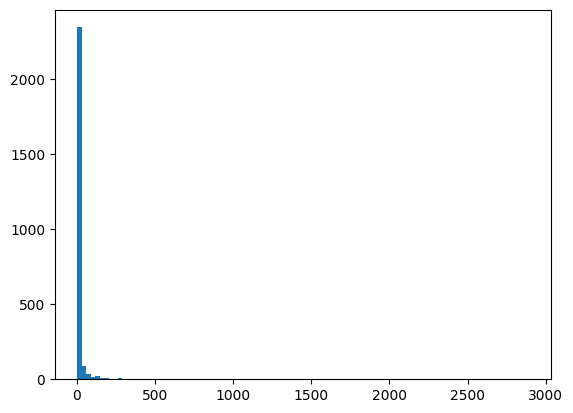

In [113]:
plt.hist(list(train_words_counts.values()), bins=100)
plt.show()

In [269]:
import seaborn as sns
# setting style
sns.set_style("darkgrid")
# setting context
sns.set_context("paper")
# setting palette
sns.set_palette("deep", color_codes=True)

In [380]:
class JFLEGDatasetEDA:

    def __init__(self, train_data, val_data, test_data, save_img_path):
        # converting the required data to pandas dataframe
        self.train_data = pd.DataFrame({
            "sentence": train_data["processed_sentence"],
            "corrections": train_data["processed_corrections"]
        })
        self.val_data = pd.DataFrame({
            "sentence": val_data["processed_sentence"],
            "corrections": val_data["processed_corrections"]
        })
        self.test_data = pd.DataFrame({
            "sentence": test_data["processed_sentence"],
            "corrections": test_data["processed_corrections"]
        })
        self.save_img_path = save_img_path
        # combining the validation and test set -- originally
        self.validation_data = pd.concat([self.val_data, self.test_data],
                                         ignore_index=True)

    def data_overview(self):
        """
        Provides an overview of the dataset statistics and examples.

        - Prints the number of samples in train, validation and test sets
        - Removes duplicates from training data to get original dataset size
        - Prints the size of original train and validation datasets
        - Shows 4 example pairs of source sentences and their corrections from the training set

        Returns:
            None
        """

        print("[INFO] Data Overview...")
        print("\t[INFO] Length of Augmented Train Dataset: ",
              len(self.train_data))
        print("\t[INFO] Length of Validation Dataset: ", len(self.val_data))
        print("\t[INFO] Length of Test Dataset: ", len(self.test_data))

        # getting rid of augmented data
        self.train_data.drop_duplicates(
            subset="sentence", keep="first", inplace=True)

        # print the original no. of samples per set
        print("\n\t[INFO] Length of Original Train Dataset: ",
              len(self.train_data))
        print("\t[INFO] Length of Original Validation Dataset: ",
              len(self.validation_data))

        # print few examples in train set
        print("\n\t[INFO] Examples from Train Dataset: ")
        for i in range(4):
            print(f"\t{i+1}.\n\tSource: {self.train_data.iloc[i, 0]}")
            print(f"\tCorrection: {self.train_data.iloc[i, 1][0]}")

    def word_count_anlysis(self):
        # count words per sentences & corrections in both dataset
        words_counts = {
            "train_sentence": self.train_data["sentence"].apply(lambda x: len(word_tokenize(x))),
            "train_correction": self.train_data["corrections"].apply(lambda x: len(word_tokenize(x[0]))),
            "val_sentence": self.val_data["sentence"].apply(lambda x: len(word_tokenize(x))),
            "val_correction": self.val_data["corrections"].apply(lambda x: len(word_tokenize(x[0]))),
        }

        # difference in both setence
        words_counts["train_diff"] = words_counts["train_correction"] - \
            words_counts["train_sentence"]
        words_counts["val_diff"] = words_counts["val_correction"] - \
            words_counts["val_sentence"]

        # printing max and min number of word in trian
        print("[INFO] Train Source:")
        print(
            f"\t-Max Number of words: {words_counts['train_sentence'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['train_sentence'].min()}")

        print("[INFO] Train Corrections:")
        print(
            f"\t-Max Number of words: {words_counts['train_correction'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['train_correction'].min()}")

        # printing max and min number of word in validation
        print("[INFO] Validation Source:")
        print(
            f"\t-Max Number of words: {words_counts['val_sentence'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['val_sentence'].min()}")

        print("[INFO] Validation Corrections:")
        print(
            f"\t-Max Number of words: {words_counts['val_correction'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['val_correction'].min()}")

        # print difference in train
        print("\n[INFO] Train Difference:")
        print(
            f"\t-Max Number of words: {words_counts['train_diff'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['train_diff'].min()}")

        # print difference in validation
        print("[INFO] Validation Difference:")
        print(
            f"\t-Max Number of words: {words_counts['val_diff'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['val_diff'].min()}")

        # distribution plot for training set
        plt.hist(words_counts["train_sentence"],
                 bins=15, alpha=0.7,
                 label="Train Source")
        plt.hist(words_counts["train_correction"],
                 bins=15, alpha=0.7,
                 label="Train Correction")
        plt.title("Word Count Distribution For Training Dataset")
        plt.xlabel("Word Counts")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "word_dis_train.png"))
        plt.show()

        # distribution plot for validation set
        plt.hist(words_counts["val_sentence"],
                 bins=15, alpha=0.7, label="Validation Source")
        plt.hist(words_counts["val_correction"],
                 bins=15, alpha=0.7,
                 label="Validation Correction")
        plt.title("Word Count Distribution For Validation Dataset")
        plt.xlabel("Word Counts")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "word_dis_val.png"))
        plt.show()

        # distribution plot for difference
        plt.hist(words_counts["train_diff"],
                 bins=15, alpha=0.7, label="Train Difference")
        plt.hist(words_counts["val_diff"],
                 bins=15, alpha=0.7,
                 label="Validation Difference")
        plt.title("Word Count Change (Correction - Source)")
        plt.xlabel("Word Count Difference")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "word_diffs.png"))
        plt.show()

        return words_counts

    def char_count_anlysis(self):
        # count chars per sentences & corrections in both dataset
        chars_counts = {
            "train_sentence": self.train_data["sentence"].apply(lambda x: len((x))),
            "train_correction": self.train_data["corrections"].apply(lambda x: len((x[0]))),
            "val_sentence": self.val_data["sentence"].apply(lambda x: len((x))),
            "val_correction": self.val_data["corrections"].apply(lambda x: len((x[0]))),
        }

        # difference in both setence
        chars_counts["train_diff"] = chars_counts["train_correction"] - \
            chars_counts["train_sentence"]
        chars_counts["val_diff"] = chars_counts["val_correction"] - \
            chars_counts["val_sentence"]

        # printing max and min number of chars in trian
        print("[INFO] Train Source:")
        print(
            f"\t-Max Number of chars: {chars_counts['train_sentence'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['train_sentence'].min()}")

        print("[INFO] Train Corrections:")
        print(
            f"\t-Max Number of chars: {chars_counts['train_correction'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['train_correction'].min()}")

        # printing max and min number of chars in validation
        print("[INFO] Validation Source:")
        print(
            f"\t-Max Number of chars: {chars_counts['val_sentence'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['val_sentence'].min()}")

        print("[INFO] Validation Corrections:")
        print(
            f"\t-Max Number of chars: {chars_counts['val_correction'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['val_correction'].min()}")

        # print difference in train
        print("\n[INFO] Train Difference:")
        print(
            f"\t-Max Number of chars: {chars_counts['train_diff'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['train_diff'].min()}")

        # print difference in validation
        print("[INFO] Validation Difference:")
        print(
            f"\t-Max Number of chars: {chars_counts['val_diff'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['val_diff'].min()}")

        # distribution plot for training set
        plt.hist(chars_counts["train_sentence"],
                 bins=15, alpha=0.7,
                 label="Train Source")
        plt.hist(chars_counts["train_correction"],
                 bins=15, alpha=0.7,
                 label="Train Correction")
        plt.title("Char Count Distribution For Training Dataset")
        plt.xlabel("Char Counts")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "char_dis_train.png"))
        plt.show()

        # distribution plot for validation set
        plt.hist(chars_counts["val_sentence"],
                 bins=15, alpha=0.7, label="Validation Source")
        plt.hist(chars_counts["val_correction"],
                 bins=15, alpha=0.7,
                 label="Validation Correction")
        plt.title("Char Count Distribution For Validation Dataset")
        plt.xlabel("Char Counts")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "char_dis_val.png"))
        plt.show()

        # distribution plot for difference
        plt.hist(chars_counts["train_diff"],
                 bins=15, alpha=0.7, label="Train Difference")
        plt.hist(chars_counts["val_diff"],
                 bins=15, alpha=0.7,
                 label="Validation Difference")
        plt.title("Char Count Change (Correction - Source)")
        plt.xlabel("Char Count Difference")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "char_diffs.png"))
        plt.show()

        return chars_counts

    def readability_anlysis(self):
        # importing textstat
        from textstat import flesch_reading_ease
        # count chars per sentences & corrections in both dataset
        readability_scores = {
            "train_sentence": self.train_data["sentence"].apply(lambda x: flesch_reading_ease((x))),
            "train_correction": self.train_data["corrections"].apply(lambda x: flesch_reading_ease((x[0]))),
            "val_sentence": self.val_data["sentence"].apply(lambda x: flesch_reading_ease((x))),
            "val_correction": self.val_data["corrections"].apply(lambda x: flesch_reading_ease((x[0]))),
        }

        # printing max and min number of readability in trian
        print("[INFO] Train Source:")
        print(
            f"\t-Max Readability Score: {readability_scores['train_sentence'].max()}")
        print(
            f"\t-Min Readability Score: {readability_scores['train_sentence'].min()}")

        print("[INFO] Train Corrections:")
        print(
            f"\t-Max Readability Score: {readability_scores['train_correction'].max()}")
        print(
            f"\t-Min Readability Score: {readability_scores['train_correction'].min()}")

        # printing max and min number of readability in validation
        print("[INFO] Validation Source:")
        print(
            f"\t-Max Readability Score: {readability_scores['val_sentence'].max()}")
        print(
            f"\t-Min Readability Score: {readability_scores['val_sentence'].min()}")

        print("[INFO] Validation Corrections:")
        print(
            f"\t-Max Readability Score: {readability_scores['val_correction'].max()}")
        print(
            f"\t-Min Readability Score: {readability_scores['val_correction'].min()}")

        # distribution plot for training set
        plt.hist(readability_scores["train_sentence"],
                 bins=15, alpha=0.7,
                 label="Train Source")
        plt.hist(readability_scores["train_correction"],
                 bins=15, alpha=0.7,
                 label="Train Correction")
        plt.title("Rreadability Scores Distribution For Training Dataset")
        plt.xlabel("Rreadability Scores")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path,
                    "readability_scores_train.png"))
        plt.show()

        # distribution plot for validation set
        plt.hist(readability_scores["val_sentence"],
                 bins=15, alpha=0.7, label="Validation Source")
        plt.hist(readability_scores["val_correction"],
                 bins=15, alpha=0.7,
                 label="Validation Correction")
        plt.title("Rreadability Scores Distribution For Validation Dataset")
        plt.xlabel("Rreadability Scores")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path,
                    "readability_scores_val.png"))
        plt.show()

        # calculate improvement in readability
        improved = readability_scores["train_correction"] > readability_scores["train_sentence"]
        # calculate change in readability
        chnage = readability_scores["train_correction"] - \
            readability_scores["train_sentence"]

        # scatter plot for training set
        sns.scatterplot(x=readability_scores["train_sentence"],
                        y=readability_scores["train_correction"],
                        hue=improved, size=abs(chnage),
                        sizes=(30, 150),
                        alpha=0.7)
        # reference line
        plt.plot([0, 120], [0, 120], "r--", alpha=0.5,
                 linewidth=1.5, label="No Chnage")
        plt.title("Source vs Corrected Rreadability For Training Dataset")
        plt.xlabel("Rreadability Scores - Source")
        plt.ylabel("Rreadability Scores - Corrected")

        # get legend
        legend = plt.legend(loc="upper left", frameon=False)
        # manually setting legend names for source and corrected
        legend_labels = ["Readability Decreased", "Readability Increased"]
        for i, text in enumerate(legend.get_texts()[:3]):
            if i < len(legend_labels):
                text.set_text(legend_labels[i])
        plt.savefig(os.path.join(self.save_img_path,
                    "readability_source_correction_scatter.png"))
        plt.show()

        return readability_scores

In [381]:
eda = JFLEGDatasetEDA(
    train, val, test, r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment2\Grammar_Correction\Images")

In [382]:
eda.data_overview()

[INFO] Data Overview...
	[INFO] Length of Augmented Train Dataset:  3016
	[INFO] Length of Validation Dataset:  672
	[INFO] Length of Test Dataset:  75

	[INFO] Length of Original Train Dataset:  754
	[INFO] Length of Original Validation Dataset:  747

	[INFO] Examples from Train Dataset: 
	1.
	Source: So I think we can not live if old people could not find siences and tecnologies and they did not developped.
	Correction: So I think we would not be alive if our ancestors did not develop sciences and technologies.
	2.
	Source: For not use car.
	Correction: Not for use with a car.
	3.
	Source: Here was no promise of morning except that we looked up through the trees we saw how low the forest had swung.
	Correction: Here was no promise of morning, except that we looked up through the trees, and we saw how low the forest had swung.
	4.
	Source: Thus even today sex is considered as the least important topic in many parts of India.
	Correction: Thus, even today, sex is considered as the leas

[INFO] Train Source:
	-Max Number of words: 80
	-Min Number of words: 1
[INFO] Train Corrections:
	-Max Number of words: 76
	-Min Number of words: 2
[INFO] Validation Source:
	-Max Number of words: 77
	-Min Number of words: 4
[INFO] Validation Corrections:
	-Max Number of words: 77
	-Min Number of words: 4

[INFO] Train Difference:
	-Max Number of words: 16
	-Min Number of words: -11
[INFO] Validation Difference:
	-Max Number of words: 10
	-Min Number of words: -9


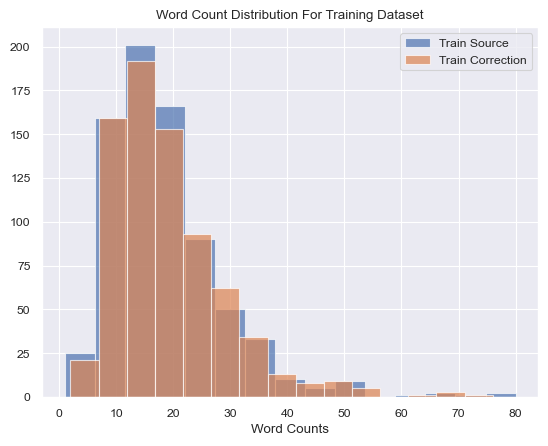

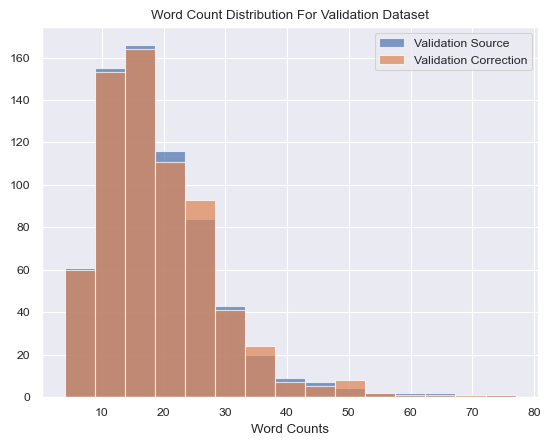

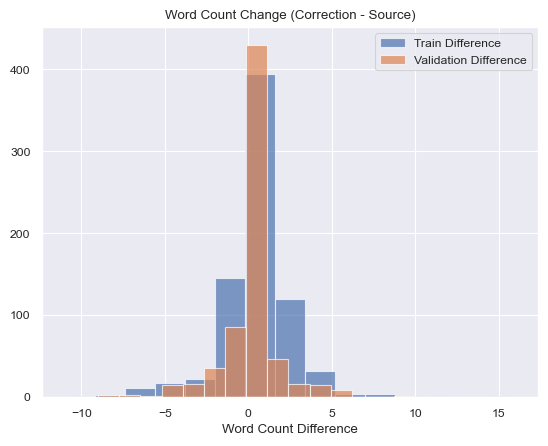

In [383]:
word_counts = eda.word_count_anlysis()

[INFO] Train Source:
	-Max Number of chars: 406
	-Min Number of chars: 5
[INFO] Train Corrections:
	-Max Number of chars: 386
	-Min Number of chars: 6
[INFO] Validation Source:
	-Max Number of chars: 409
	-Min Number of chars: 11
[INFO] Validation Corrections:
	-Max Number of chars: 406
	-Min Number of chars: 11

[INFO] Train Difference:
	-Max Number of chars: 80
	-Min Number of chars: -40
[INFO] Validation Difference:
	-Max Number of chars: 46
	-Min Number of chars: -49


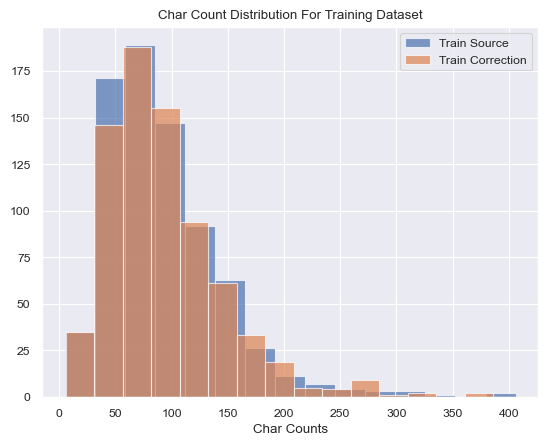

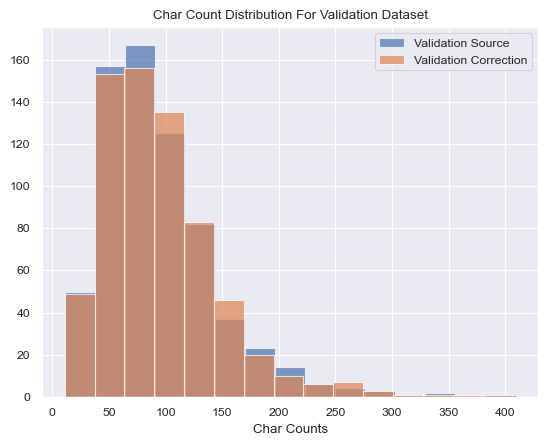

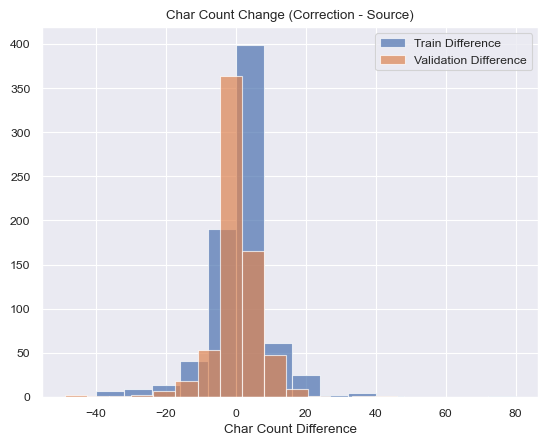

In [384]:
char_words = eda.char_count_anlysis()

[INFO] Train Source:
	-Max Readability Score: 121.22000000000003
	-Min Readability Score: -14.814999999999998
[INFO] Train Corrections:
	-Max Readability Score: 121.22000000000003
	-Min Readability Score: -44.50999999999999
[INFO] Validation Source:
	-Max Readability Score: 120.20500000000001
	-Min Readability Score: -8.724999999999994
[INFO] Validation Corrections:
	-Max Readability Score: 119.19000000000003
	-Min Readability Score: -35.11999999999995


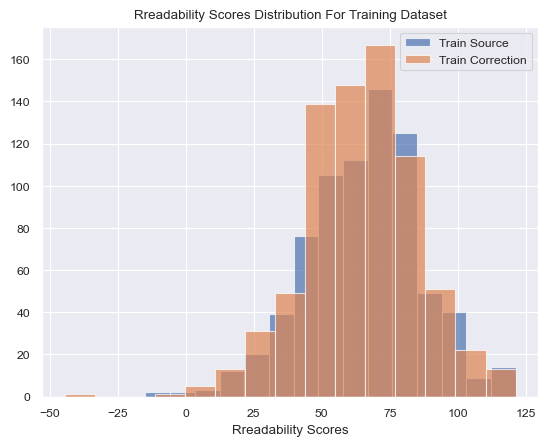

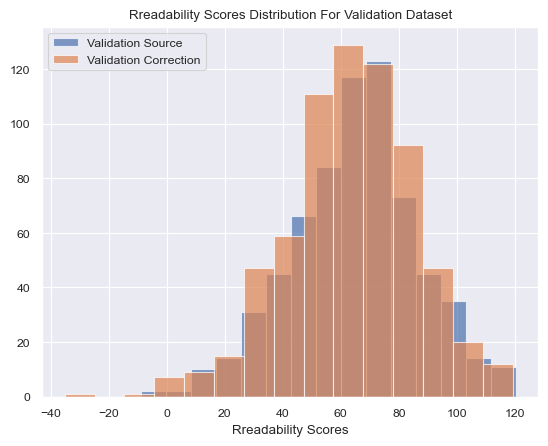

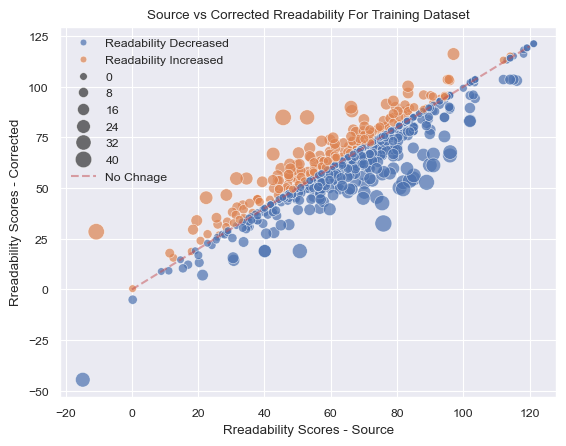

In [385]:
readability_scores = eda.readability_anlysis()